In [6]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

In [7]:
# Importing basic functions from other notebooks 
import import_ipynb
from analyze_data_cleaned import compute_symptoms_occurences_dataframe
from analyze_data_cleaned import plot_symptoms_occurences

# to be removed once i know how to import these from another notebook

In [35]:
def prepro_missing_values(df_train_label):
    """
    Filling NaN values with -1. 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    # Replace NaN values with -1.0 because otherwise plotting triggers an error
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label


def compute_symptoms_occurences_dataframe(df_train_label):
    """
    Computes how many times the symptoms are occuring for a single subject_id 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    df_train_label = prepro_missing_values(df_train_label=df_train_label)

    # Group data by subject_id
    df_train_label_subject_id = df_train_label.groupby("subject_id")

    df_occurences = []
    symptoms = ["on_off", "dyskinesia", "tremor"]

    for key, value in df_train_label_subject_id:
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = (
                df_train_label_subject_id.get_group(key)
                .iloc[:, -3:][symptom]
                .value_counts()
            )

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(
                    (
                        {
                            "subject_id": key,
                            "symptom": symptom,
                            "symptom_value": symptom_value,
                            "occurence": symptom_occurence,
                        }
                    )
                )

    df_occurences = pd.DataFrame(
        df_occurences, columns=("subject_id", "symptom", "symptom_value", "occurence")
    )

    return df_occurences, df_train_label_subject_id

In [46]:
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    """
    This function plots the occurences of symptoms according to subject_id 

    Keyword Arguments: 
    - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
    - df_train_label_subject_id: contains df_train_label grouped by subject_id 
    """

    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = (
        df_occurences.subject_id.nunique()
    )  # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 5
    fig, axes = plt.subplots(
        nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
    )  # 3 cols for the 3 symptoms

    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
    # it is incremented
    patient = -1
    
    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ["on_off", "dyskinesia", "tremor"]
    for key, value in df_train_label_subject_id:
        patient = patient + 1  # value used to position the plots (row)
        symptom_no = 0  # value only used to position the plots (col)
        for symptom in symptoms:

            subject_symptom = " ".join(
                [str(key), symptom]
            )  # variable used to create a title for each plot

            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
                kind="bar",
                x=symptom,
                title=subject_symptom,
                ax=axes[symptom_no],
                sharey=True,
            )
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1
        plt.show()
            

### Analyze the kfold distribution 

1004_train_kfold_0.csv
Nb subject_id :  1


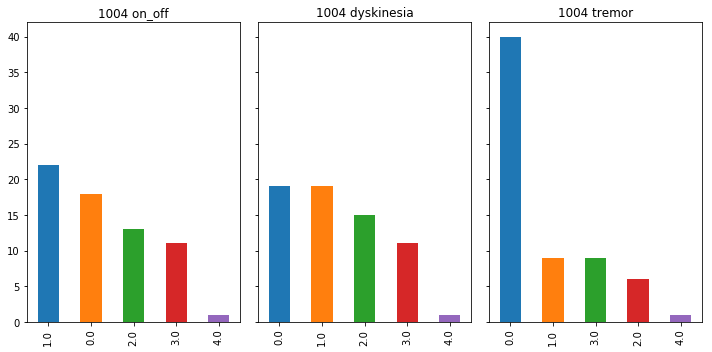

1004_test_kfold_0.csv
Nb subject_id :  1


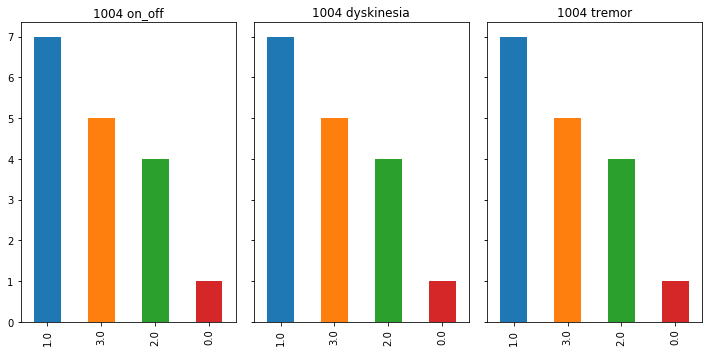

1004_train_kfold_1.csv
Nb subject_id :  1


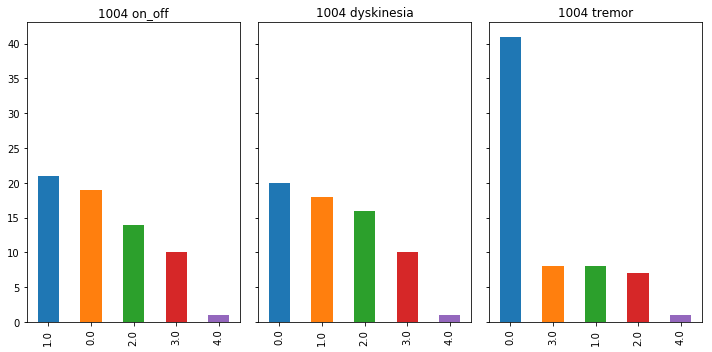

1004_test_kfold_1.csv
Nb subject_id :  1


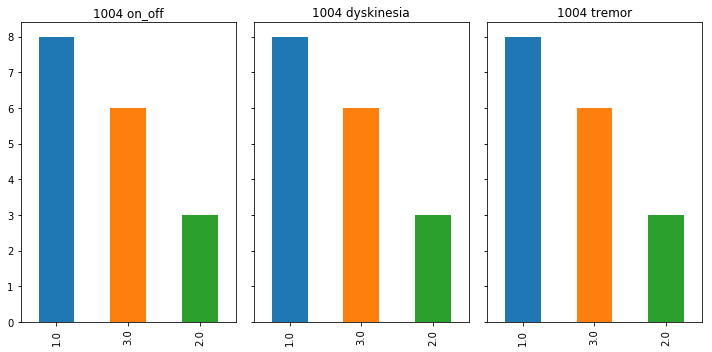

1004_train_kfold_2.csv
Nb subject_id :  1


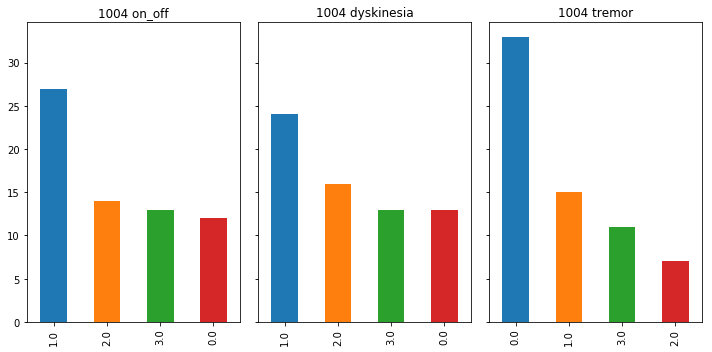

1004_test_kfold_2.csv
Nb subject_id :  1


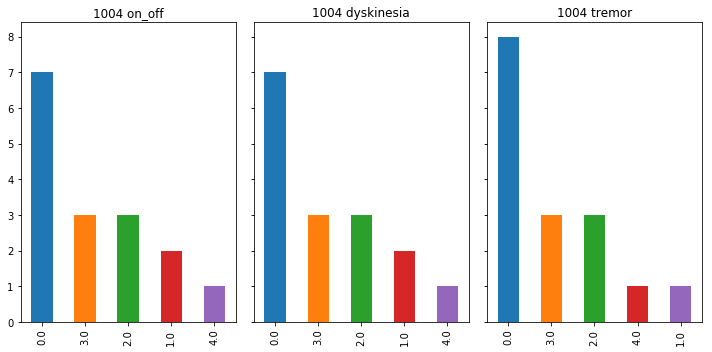

1004_train_kfold_3.csv
Nb subject_id :  1


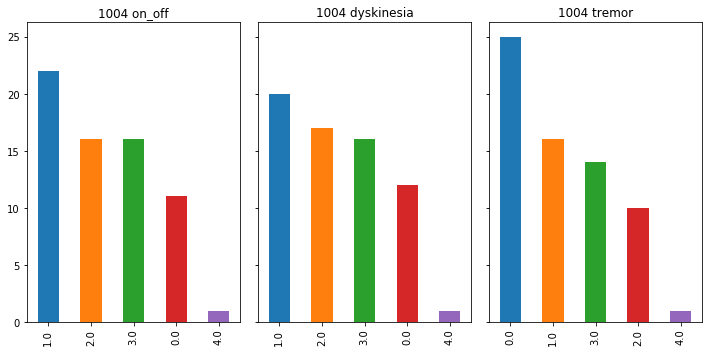

1004_test_kfold_3.csv
Nb subject_id :  1


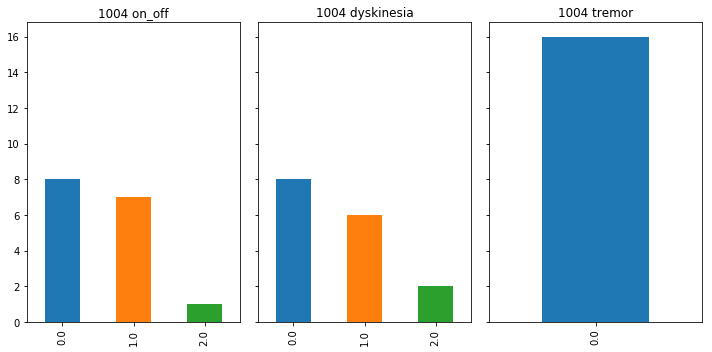

1004_train_kfold_4.csv
Nb subject_id :  1


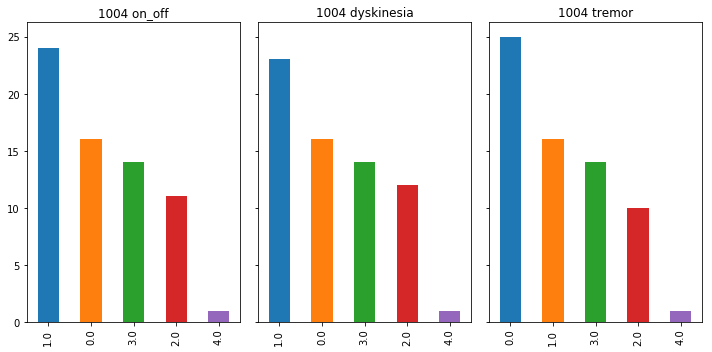

1004_test_kfold_4.csv
Nb subject_id :  1


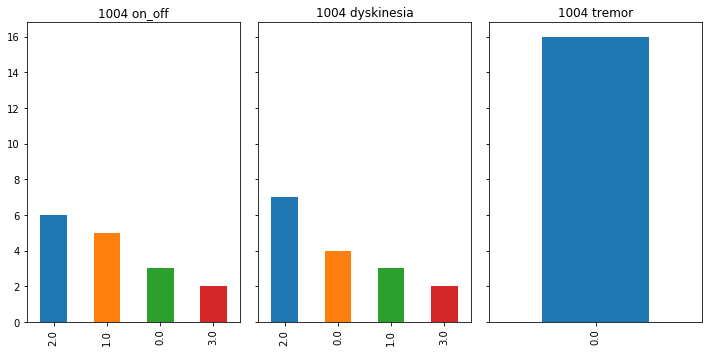

1006_train_kfold_0.csv
Nb subject_id :  1


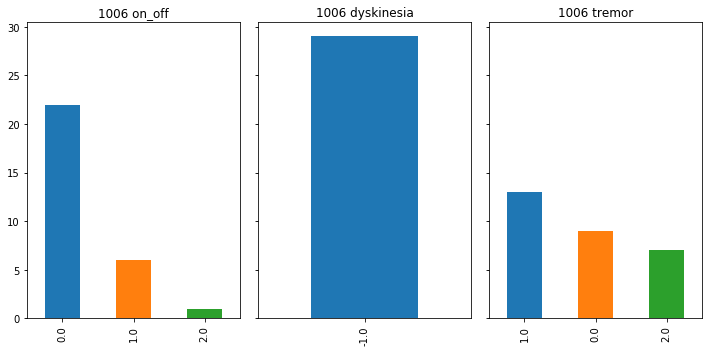

1006_test_kfold_0.csv
Nb subject_id :  1


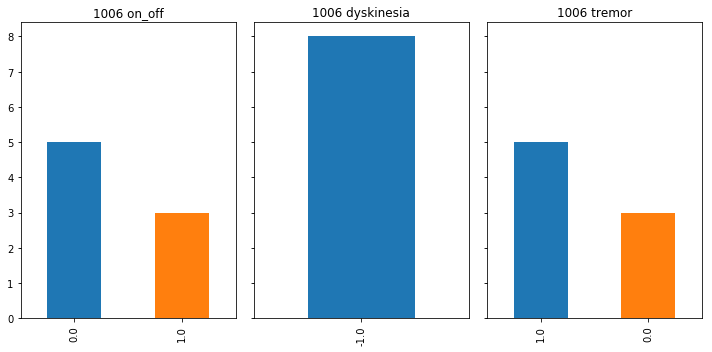

1006_train_kfold_1.csv
Nb subject_id :  1


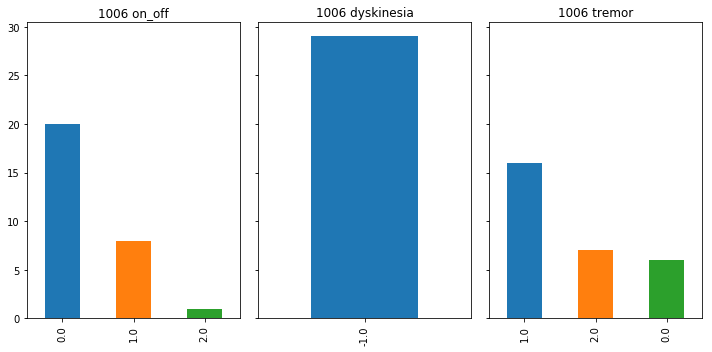

1006_test_kfold_1.csv
Nb subject_id :  1


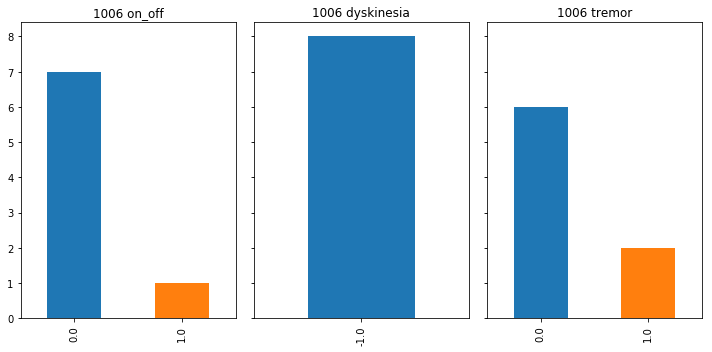

1006_train_kfold_2.csv
Nb subject_id :  1


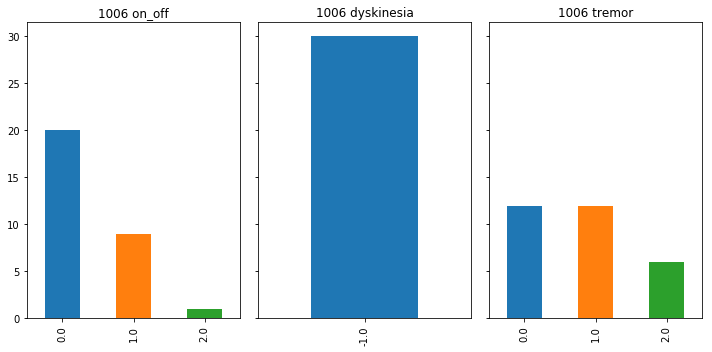

1006_test_kfold_2.csv
Nb subject_id :  1


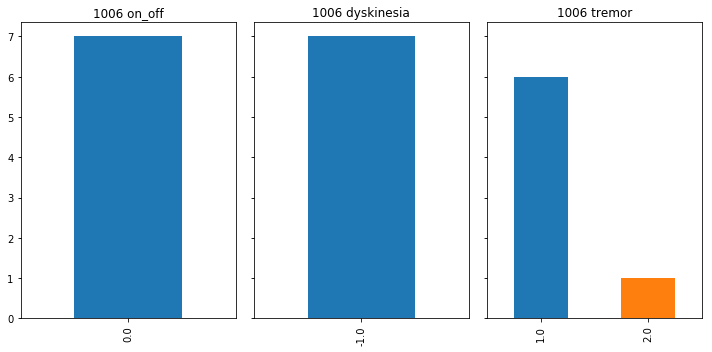

1006_train_kfold_3.csv
Nb subject_id :  1


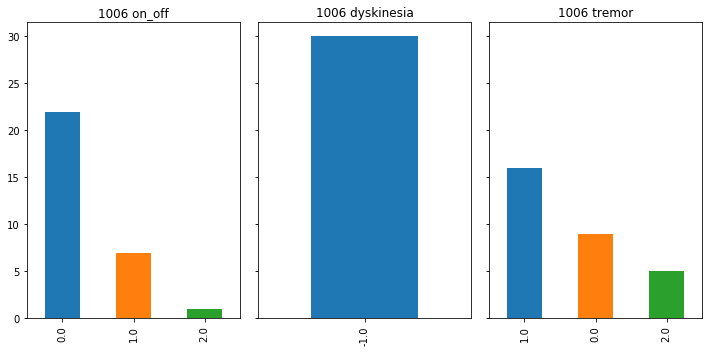

1006_test_kfold_3.csv
Nb subject_id :  1


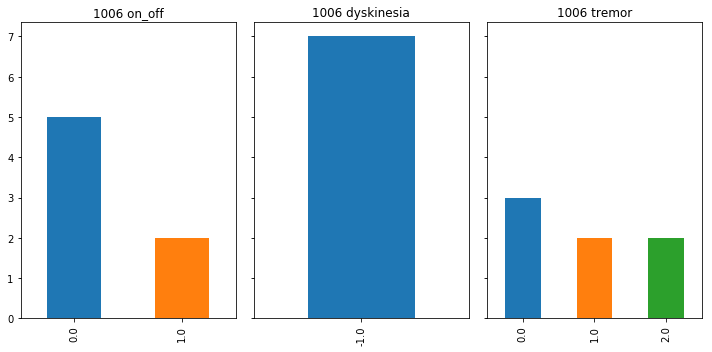

1006_train_kfold_4.csv
Nb subject_id :  1


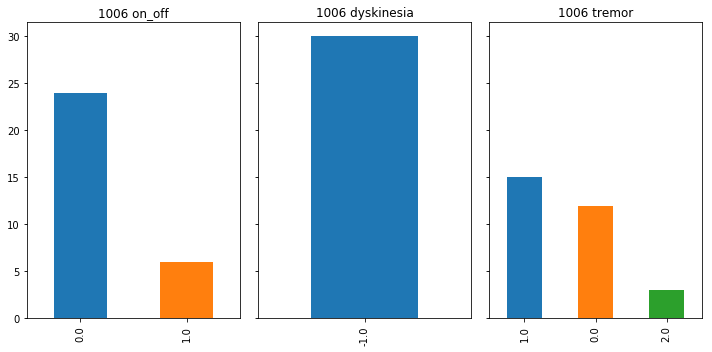

1006_test_kfold_4.csv
Nb subject_id :  1


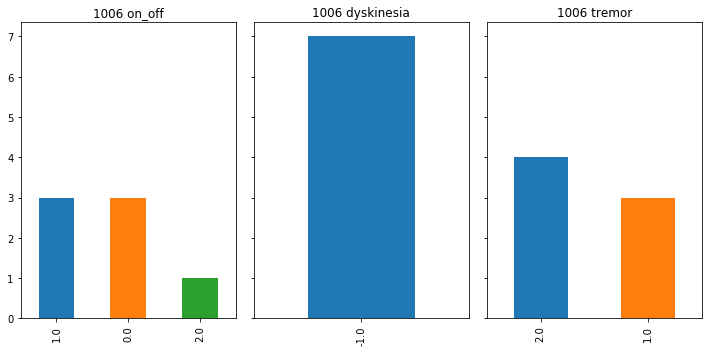

1007_train_kfold_0.csv
Nb subject_id :  1


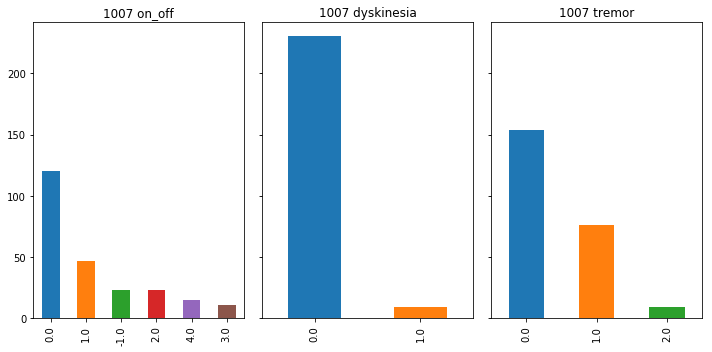

1007_test_kfold_0.csv
Nb subject_id :  1


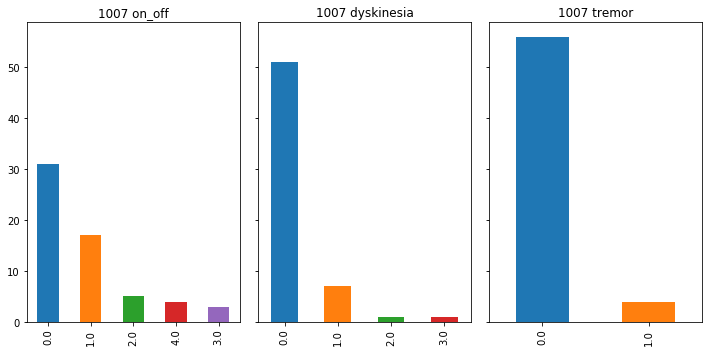

1007_train_kfold_1.csv
Nb subject_id :  1


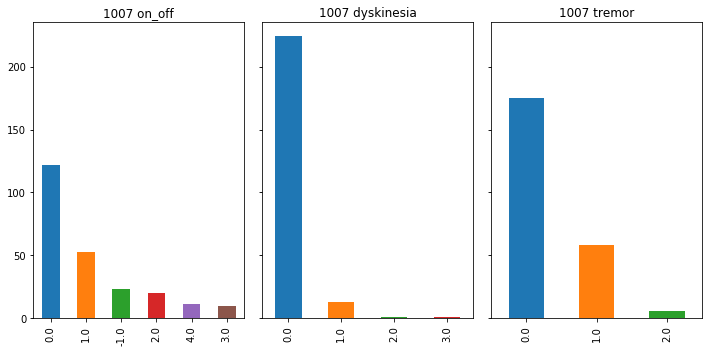

1007_test_kfold_1.csv
Nb subject_id :  1


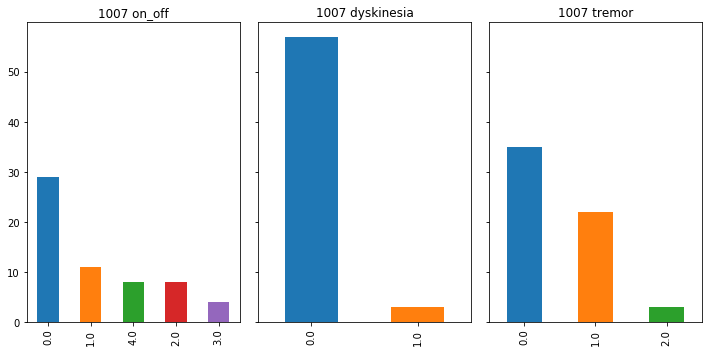

1007_train_kfold_2.csv
Nb subject_id :  1


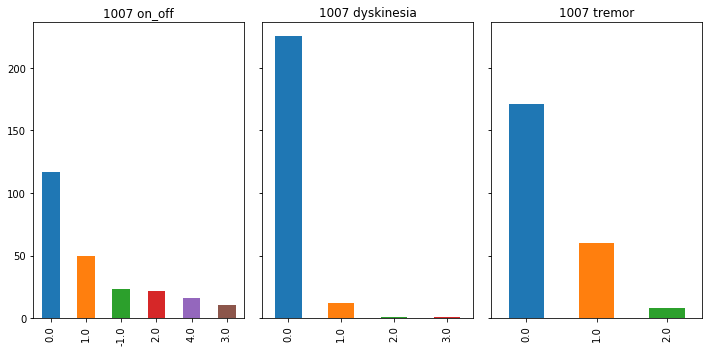

1007_test_kfold_2.csv
Nb subject_id :  1


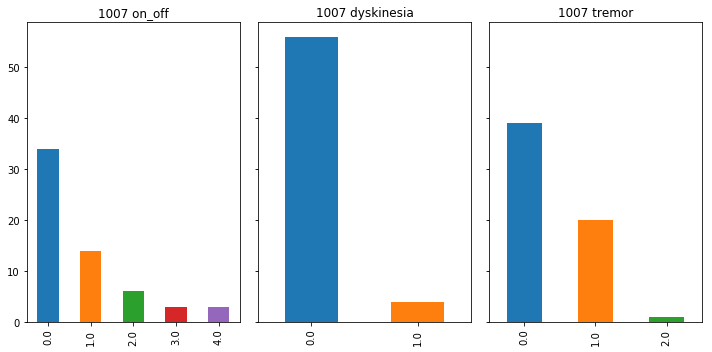

1007_train_kfold_3.csv
Nb subject_id :  1


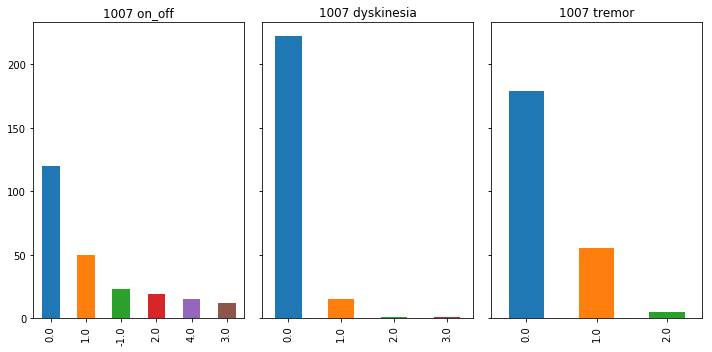

1007_test_kfold_3.csv
Nb subject_id :  1


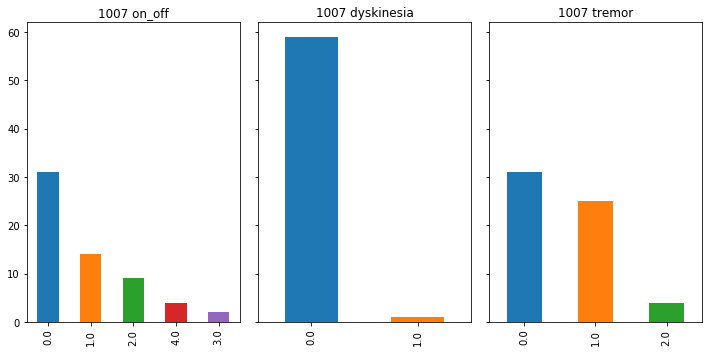

1007_train_kfold_4.csv
Nb subject_id :  1


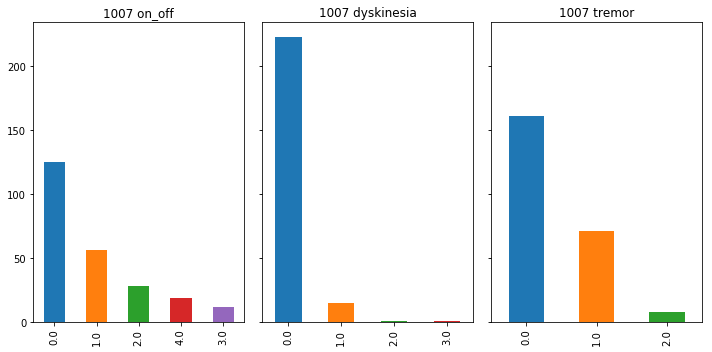

1007_test_kfold_4.csv
Nb subject_id :  1


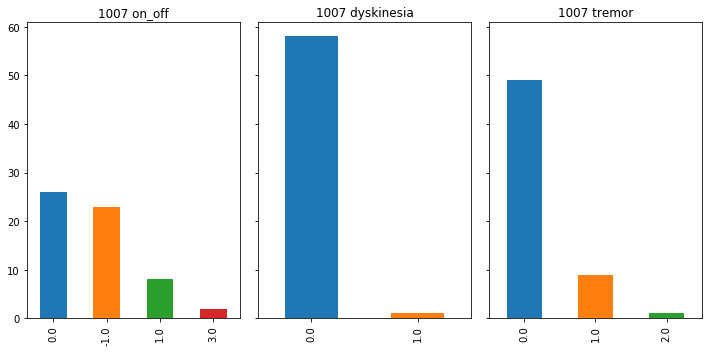

1019_train_kfold_0.csv
Nb subject_id :  1


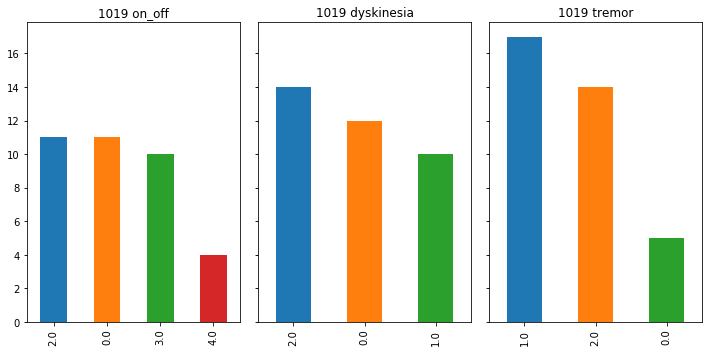

1019_test_kfold_0.csv
Nb subject_id :  1


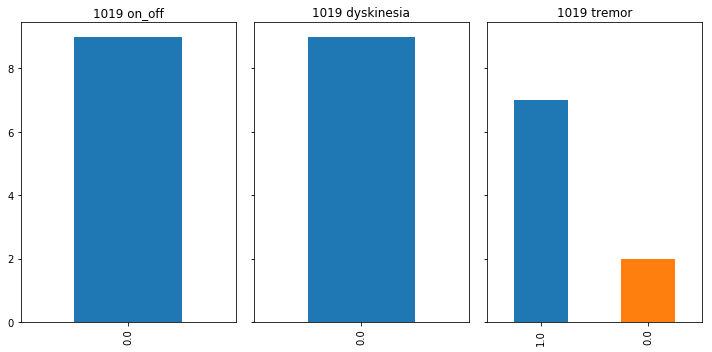

1019_train_kfold_1.csv
Nb subject_id :  1


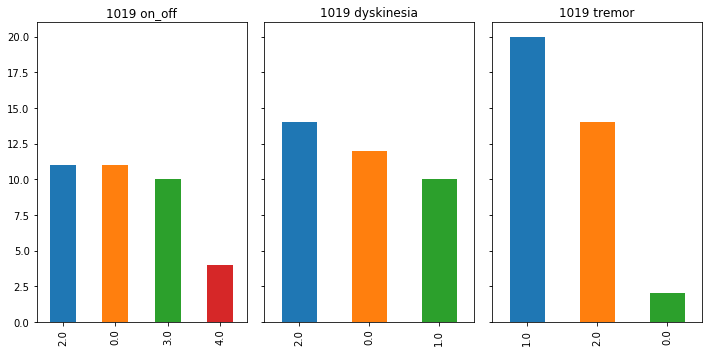

1019_test_kfold_1.csv
Nb subject_id :  1


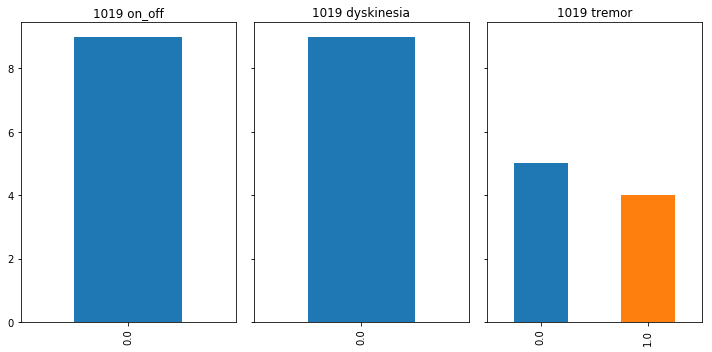

1019_train_kfold_2.csv
Nb subject_id :  1


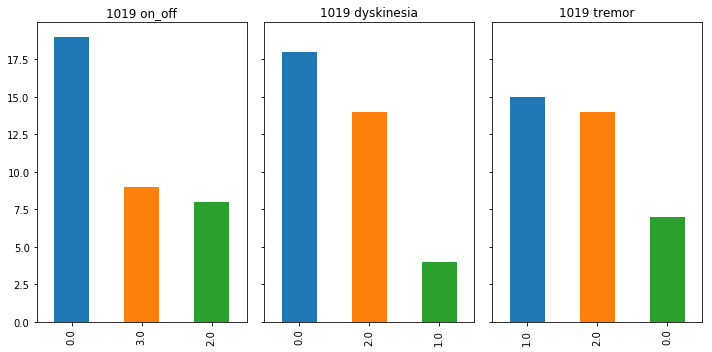

1019_test_kfold_2.csv
Nb subject_id :  1


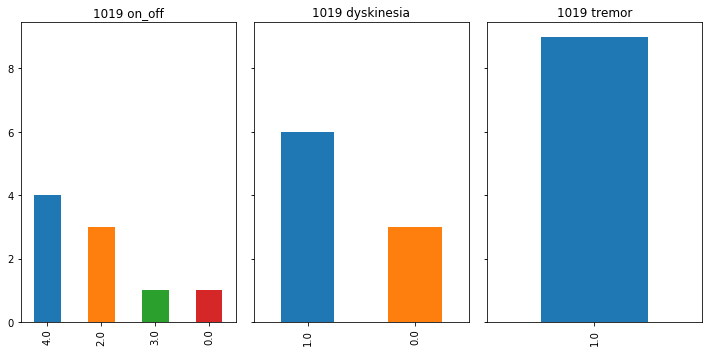

1019_train_kfold_3.csv
Nb subject_id :  1


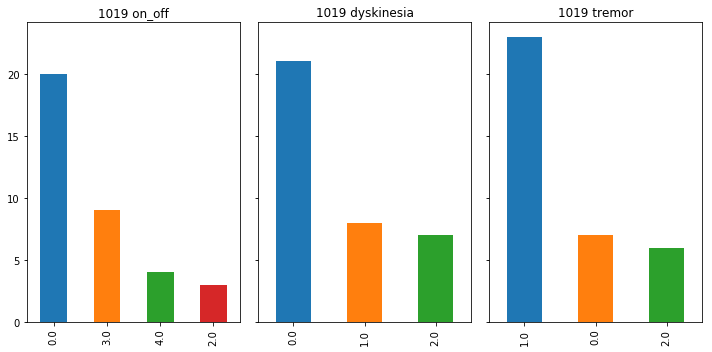

1019_test_kfold_3.csv
Nb subject_id :  1


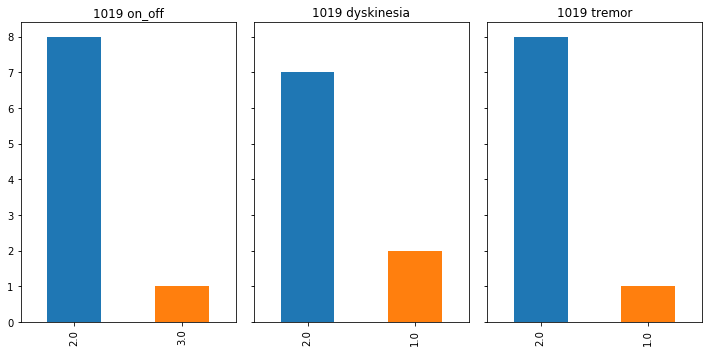

1019_train_kfold_4.csv
Nb subject_id :  1


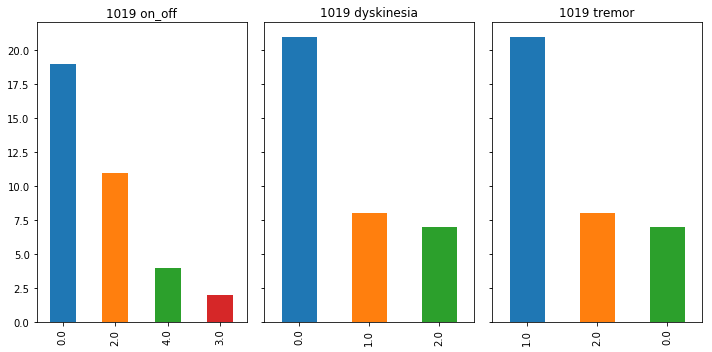

1019_test_kfold_4.csv
Nb subject_id :  1


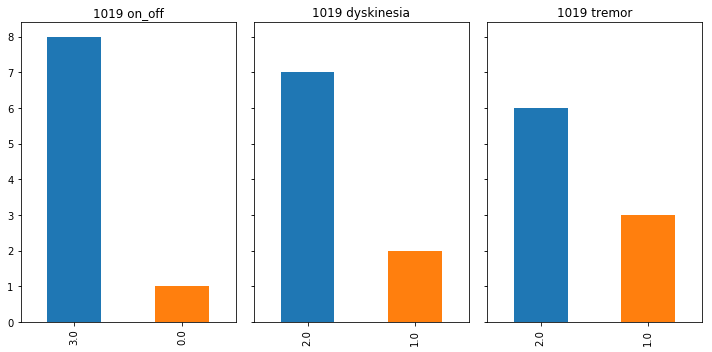

1020_train_kfold_0.csv
Nb subject_id :  1


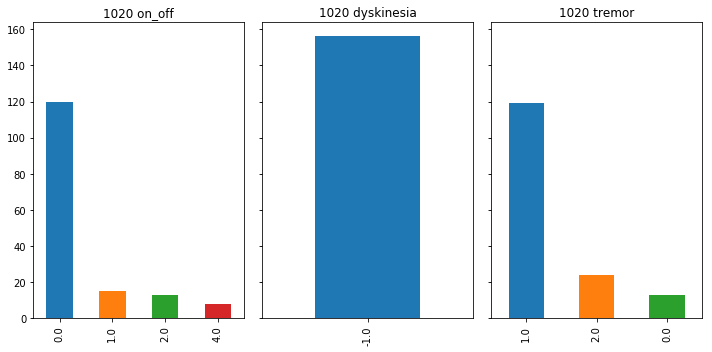

1020_test_kfold_0.csv
Nb subject_id :  1


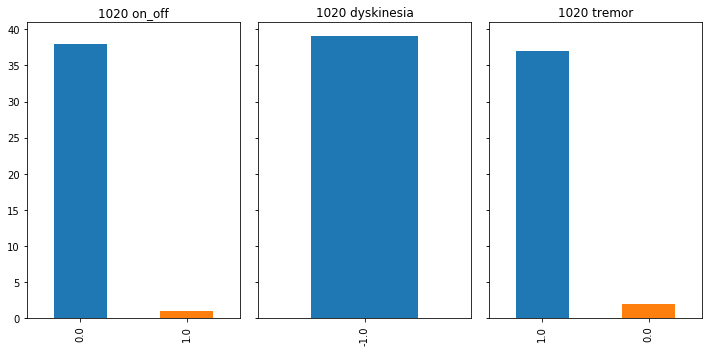

1020_train_kfold_1.csv
Nb subject_id :  1


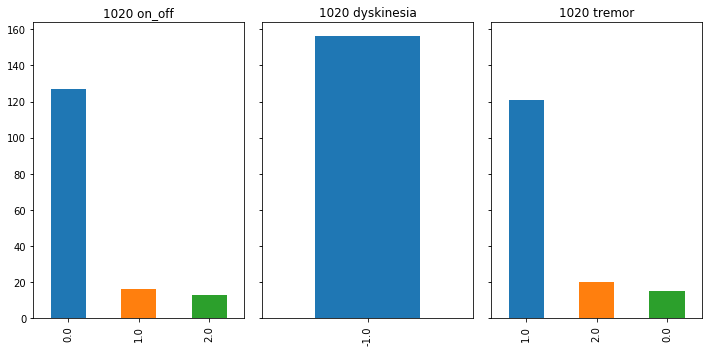

1020_test_kfold_1.csv
Nb subject_id :  1


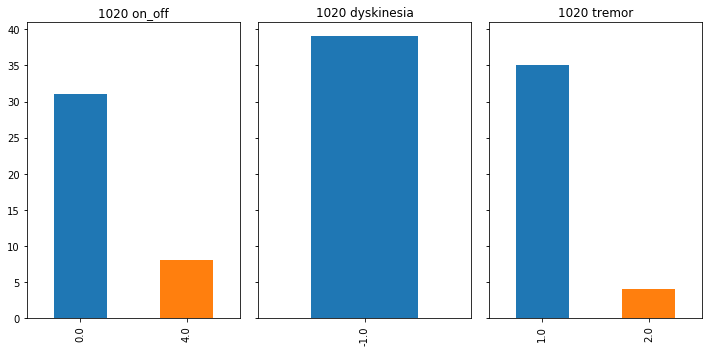

1020_train_kfold_2.csv
Nb subject_id :  1


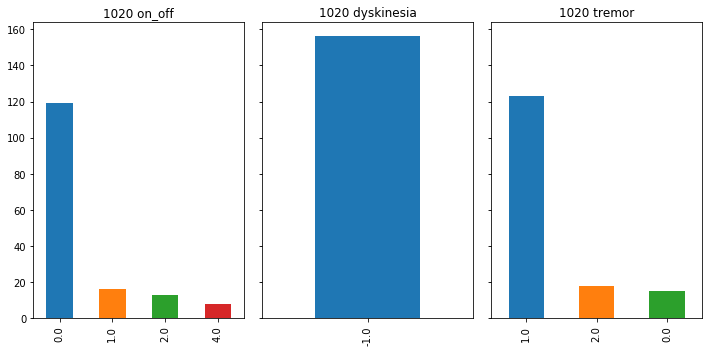

1020_test_kfold_2.csv
Nb subject_id :  1


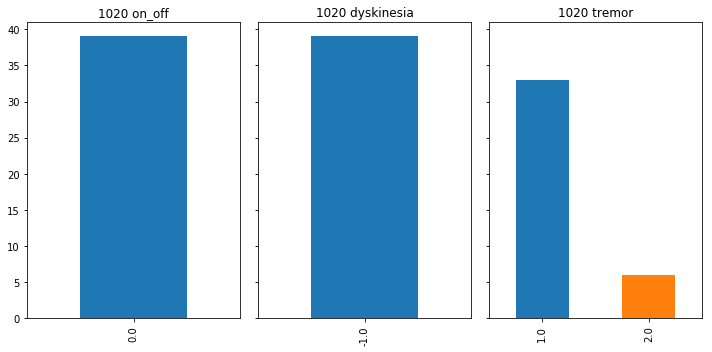

1020_train_kfold_3.csv
Nb subject_id :  1


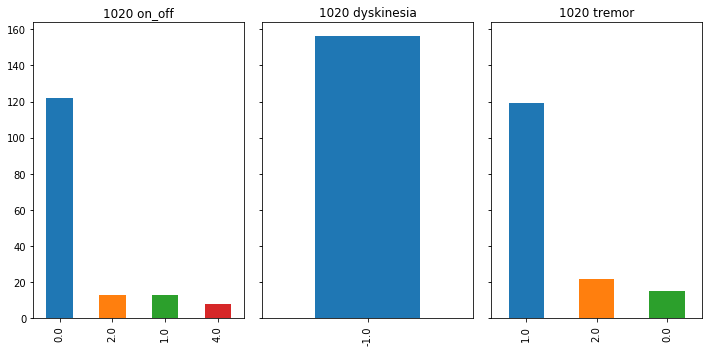

1020_test_kfold_3.csv
Nb subject_id :  1


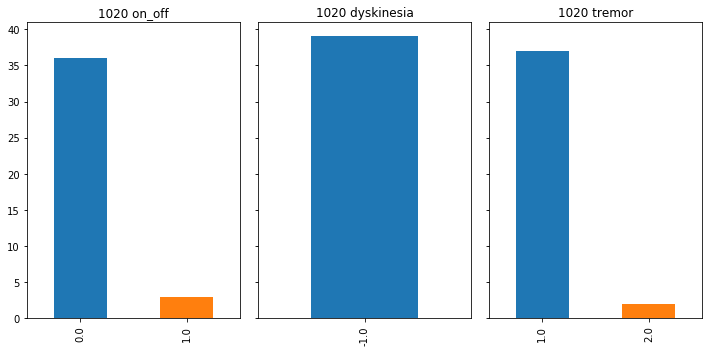

1020_train_kfold_4.csv
Nb subject_id :  1


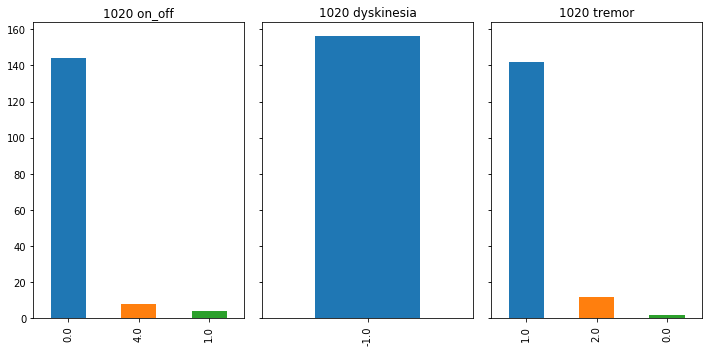

1020_test_kfold_4.csv
Nb subject_id :  1


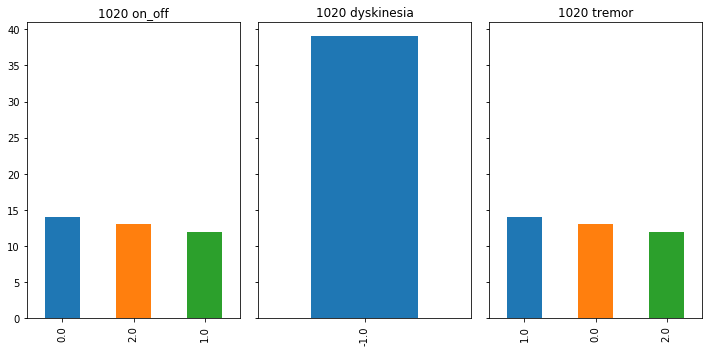

1023_train_kfold_0.csv
Nb subject_id :  1


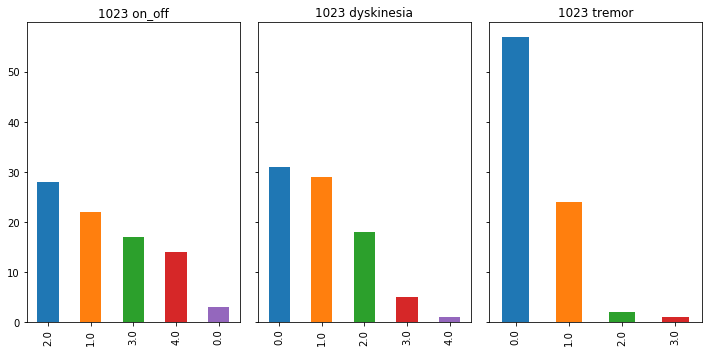

1023_test_kfold_0.csv
Nb subject_id :  1


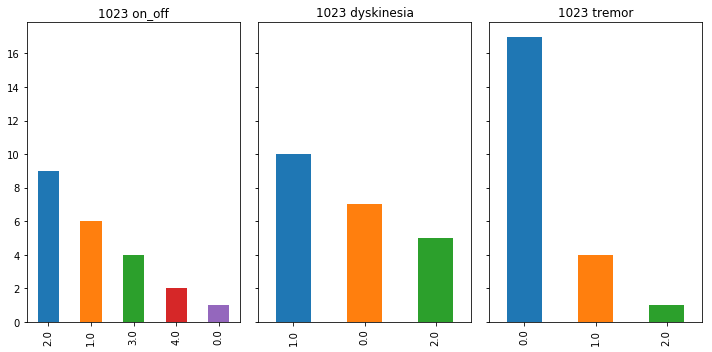

1023_train_kfold_1.csv
Nb subject_id :  1


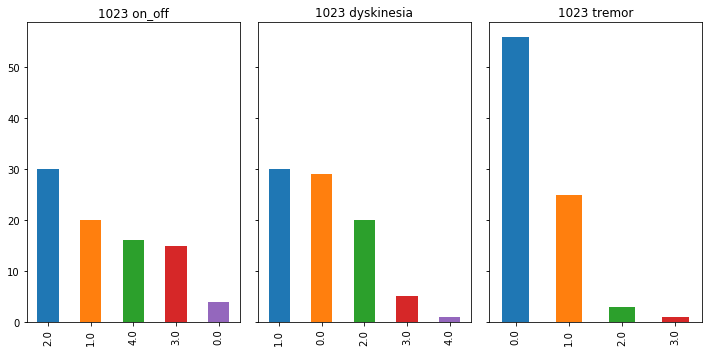

1023_test_kfold_1.csv
Nb subject_id :  1


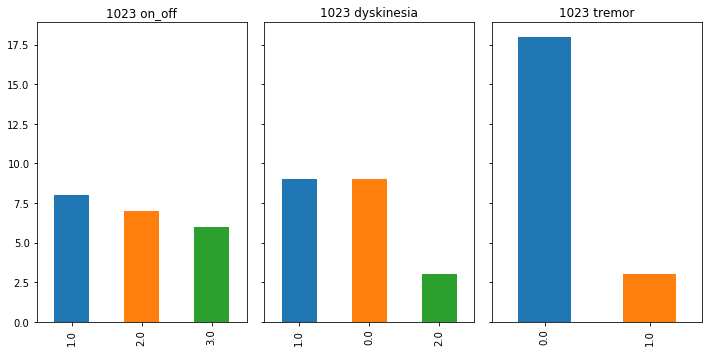

1023_train_kfold_2.csv
Nb subject_id :  1


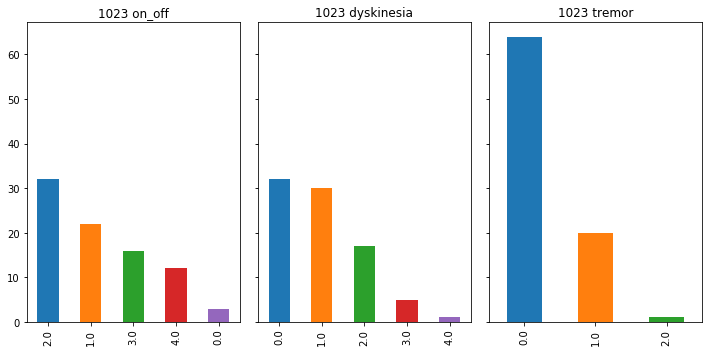

1023_test_kfold_2.csv
Nb subject_id :  1


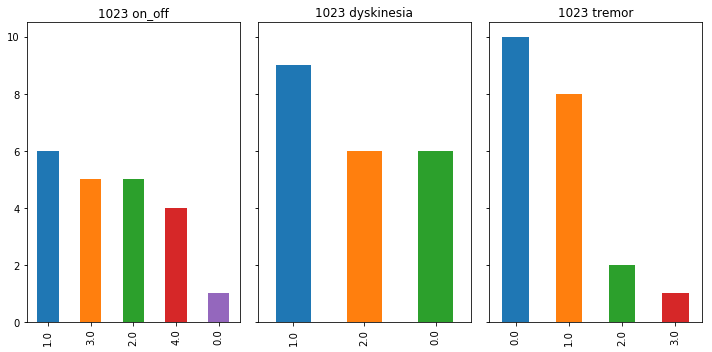

1023_train_kfold_3.csv
Nb subject_id :  1


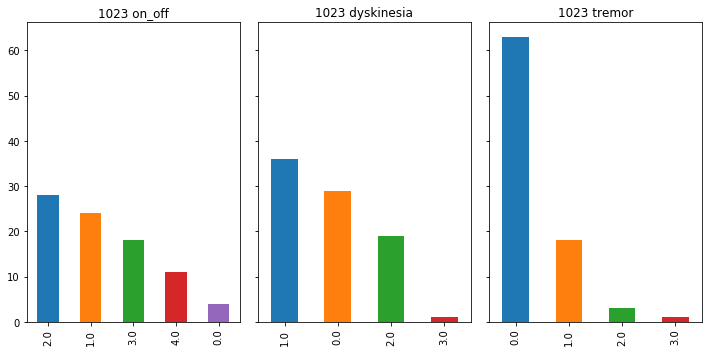

1023_test_kfold_3.csv
Nb subject_id :  1


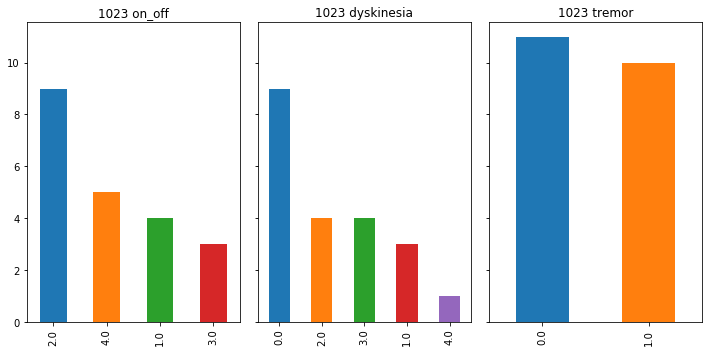

1023_train_kfold_4.csv
Nb subject_id :  1


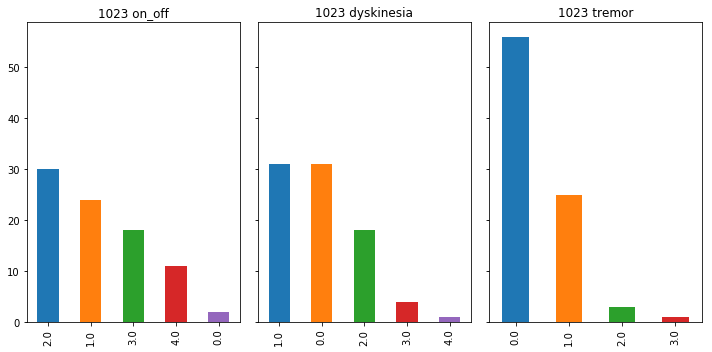

1023_test_kfold_4.csv
Nb subject_id :  1


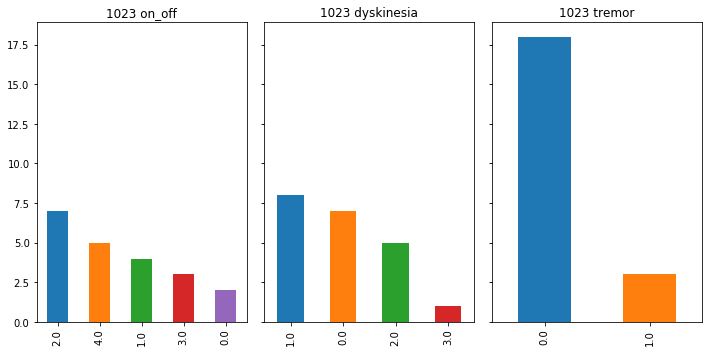

1032_train_kfold_0.csv
Nb subject_id :  1


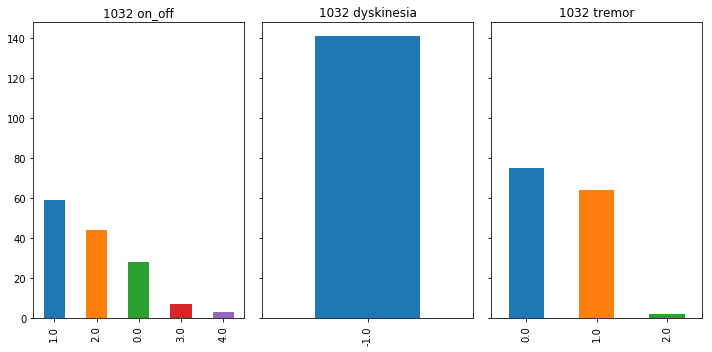

1032_test_kfold_0.csv
Nb subject_id :  1


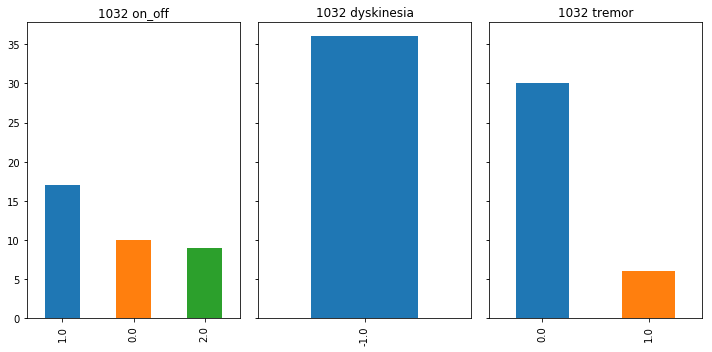

1032_train_kfold_1.csv
Nb subject_id :  1


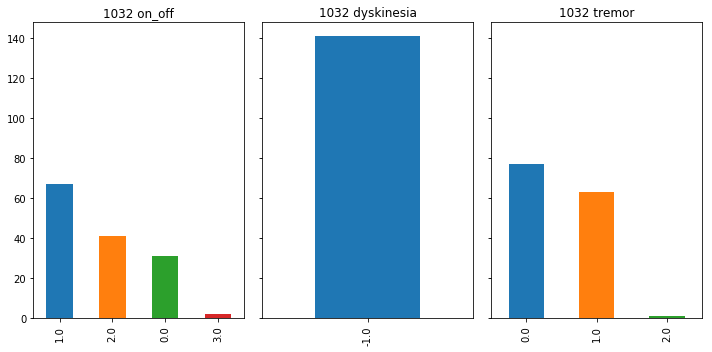

1032_test_kfold_1.csv
Nb subject_id :  1


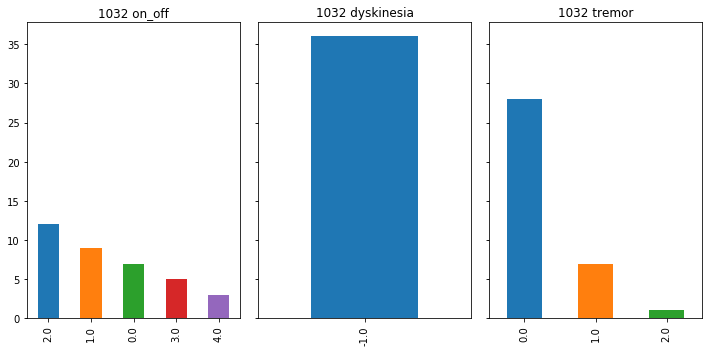

1032_train_kfold_2.csv
Nb subject_id :  1


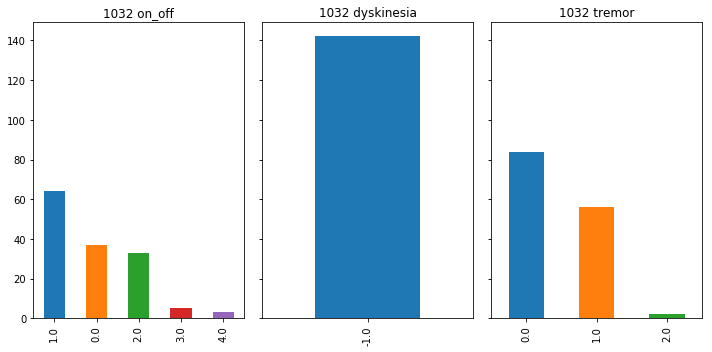

1032_test_kfold_2.csv
Nb subject_id :  1


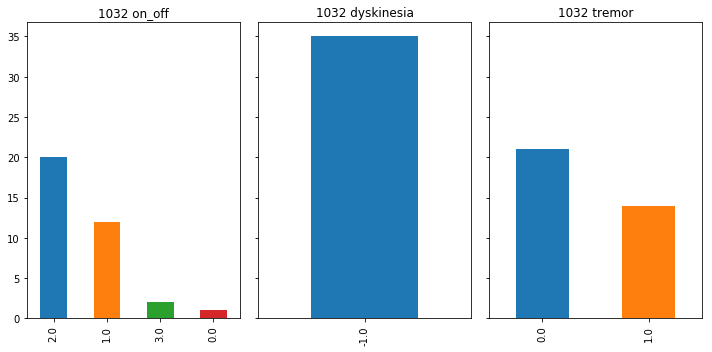

1032_train_kfold_3.csv
Nb subject_id :  1


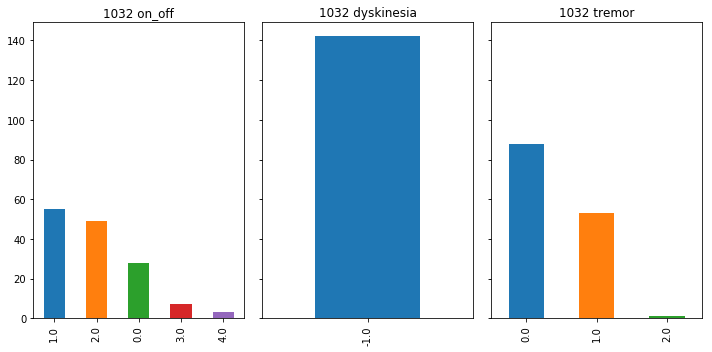

1032_test_kfold_3.csv
Nb subject_id :  1


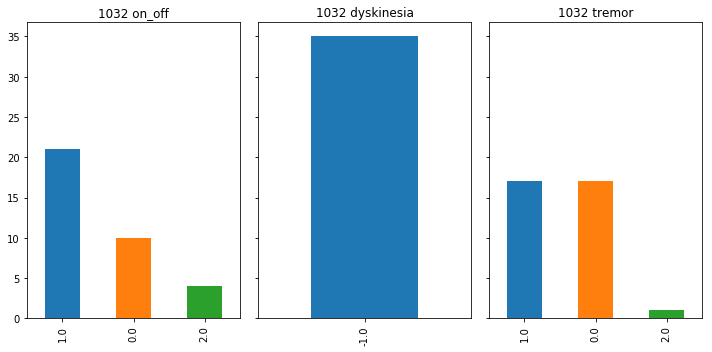

1032_train_kfold_4.csv
Nb subject_id :  1


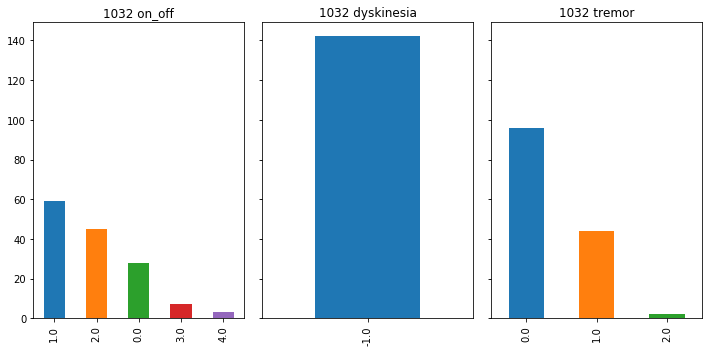

1032_test_kfold_4.csv
Nb subject_id :  1


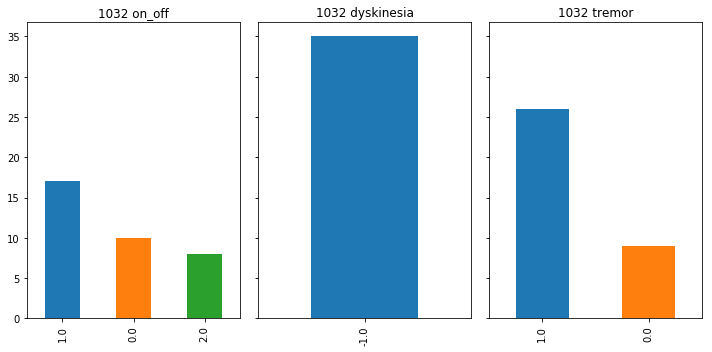

1034_train_kfold_0.csv
Nb subject_id :  1


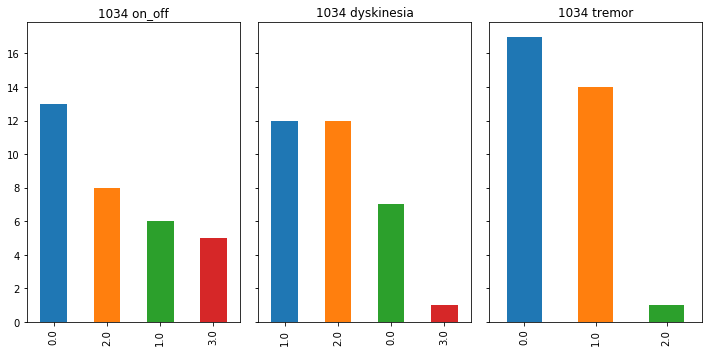

1034_test_kfold_0.csv
Nb subject_id :  1


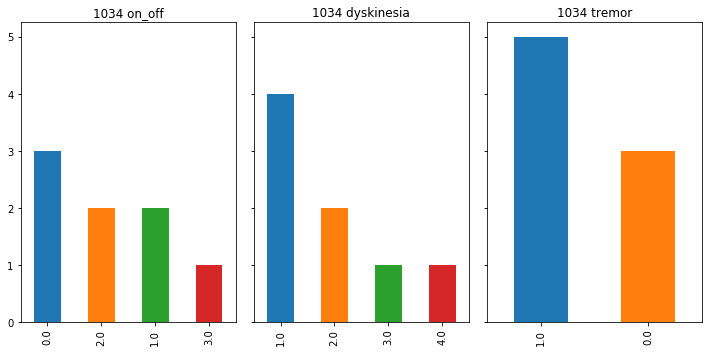

1034_train_kfold_1.csv
Nb subject_id :  1


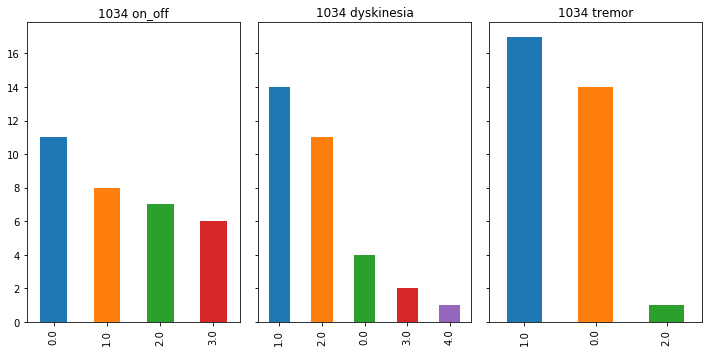

1034_test_kfold_1.csv
Nb subject_id :  1


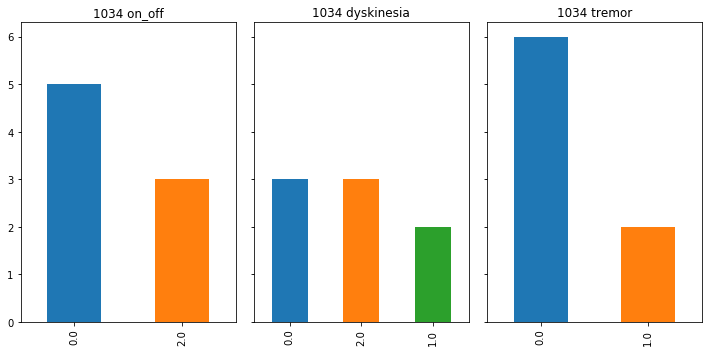

1034_train_kfold_2.csv
Nb subject_id :  1


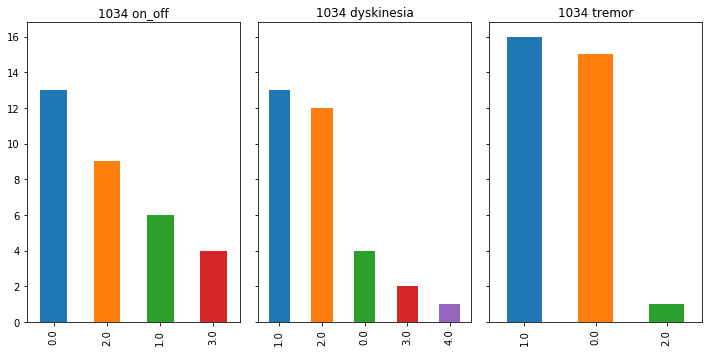

1034_test_kfold_2.csv
Nb subject_id :  1


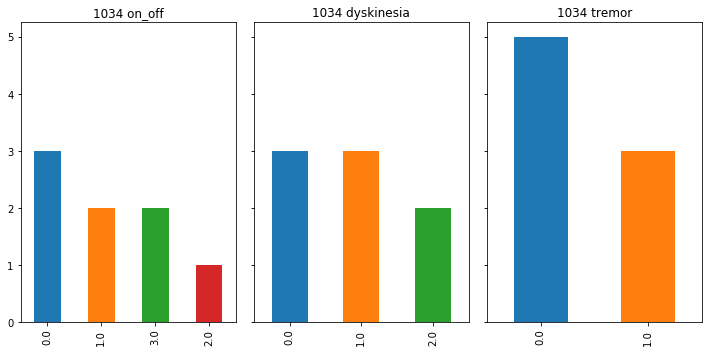

1034_train_kfold_3.csv
Nb subject_id :  1


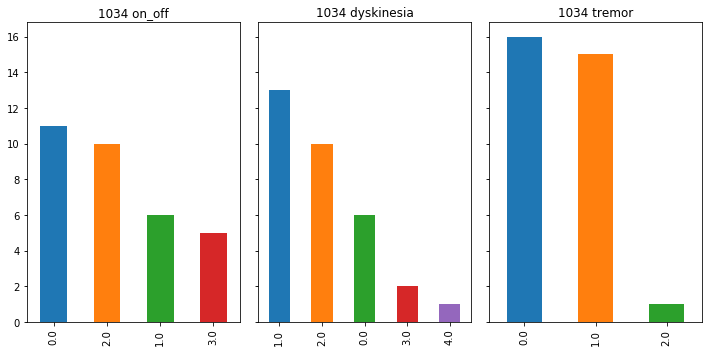

1034_test_kfold_3.csv
Nb subject_id :  1


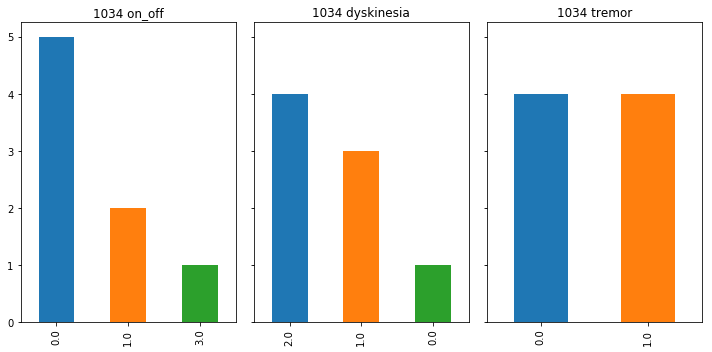

1034_train_kfold_4.csv
Nb subject_id :  1


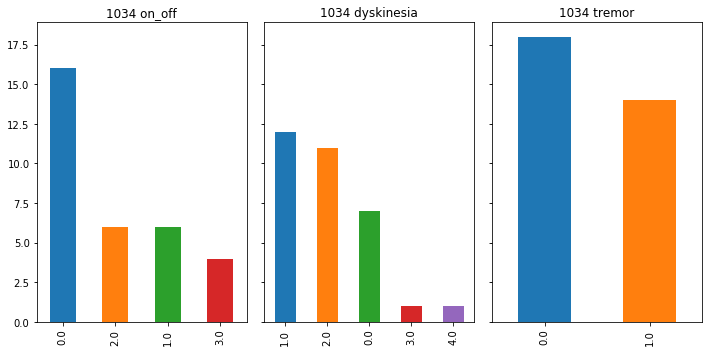

1034_test_kfold_4.csv
Nb subject_id :  1


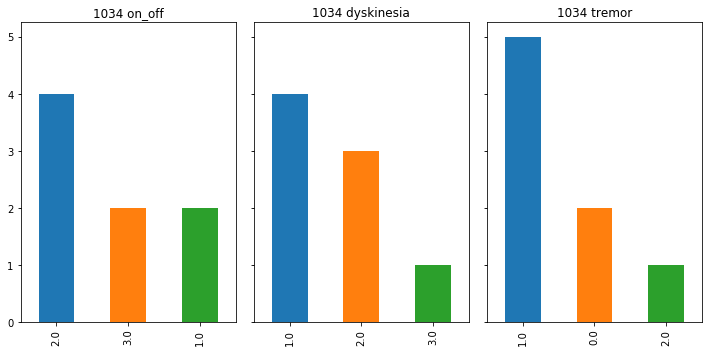

1038_train_kfold_0.csv
Nb subject_id :  1


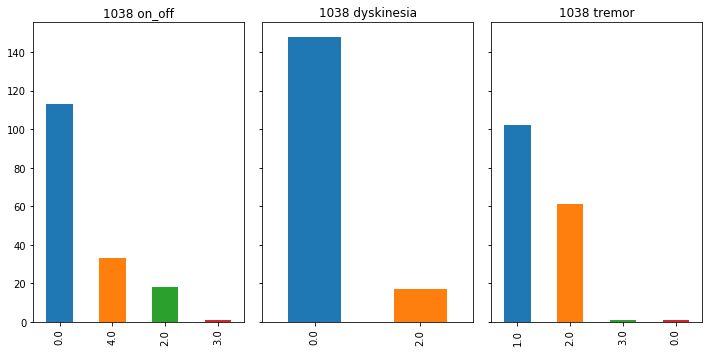

1038_test_kfold_0.csv
Nb subject_id :  1


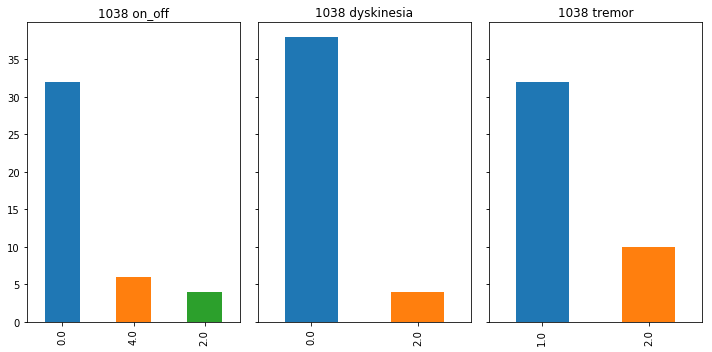

1038_train_kfold_1.csv
Nb subject_id :  1


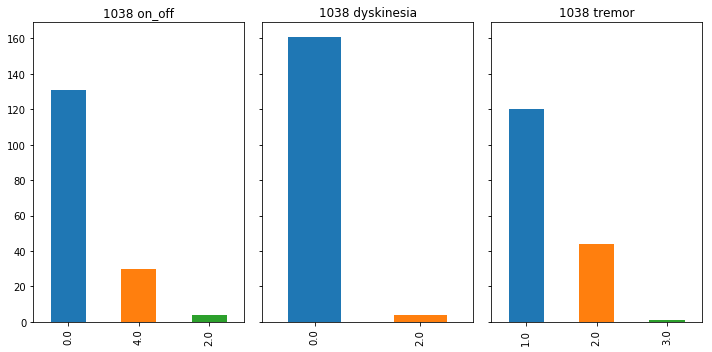

1038_test_kfold_1.csv
Nb subject_id :  1


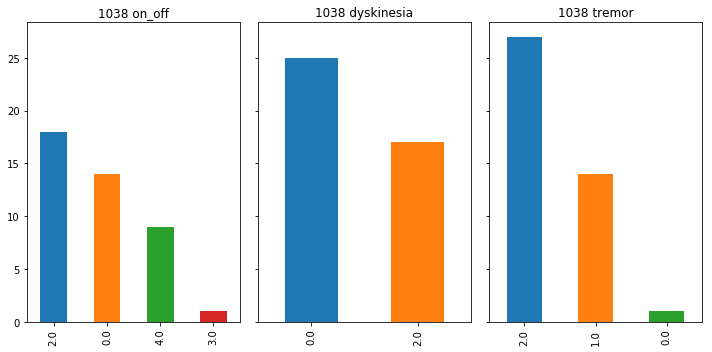

1038_train_kfold_2.csv
Nb subject_id :  1


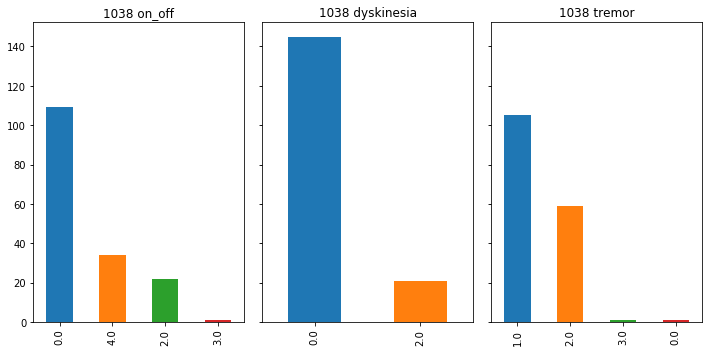

1038_test_kfold_2.csv
Nb subject_id :  1


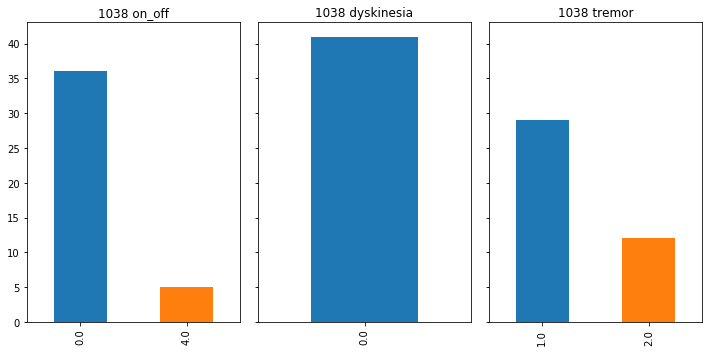

1038_train_kfold_3.csv
Nb subject_id :  1


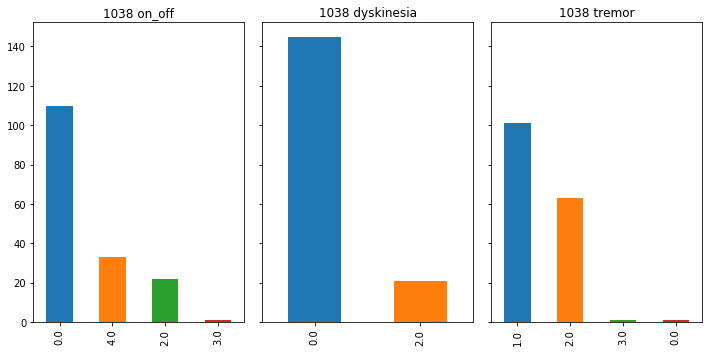

1038_test_kfold_3.csv
Nb subject_id :  1


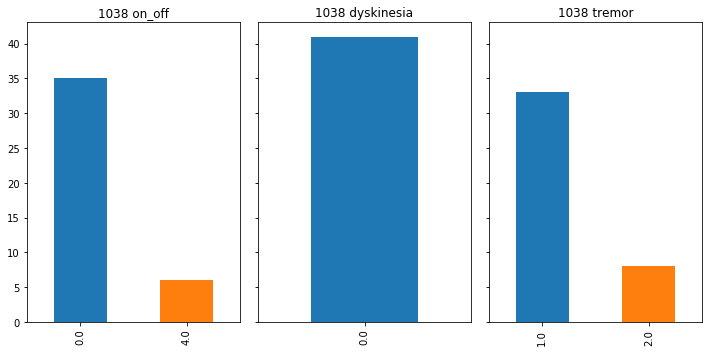

1038_train_kfold_4.csv
Nb subject_id :  1


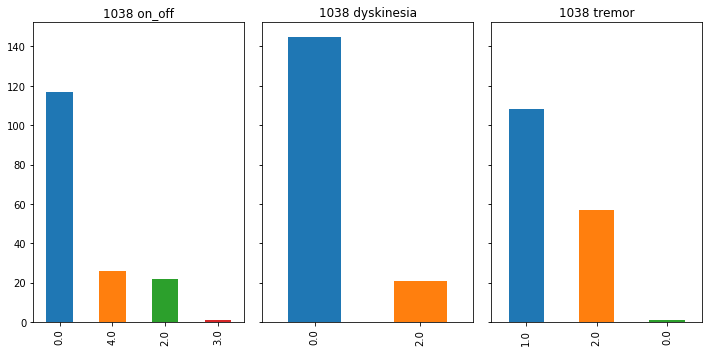

1038_test_kfold_4.csv
Nb subject_id :  1


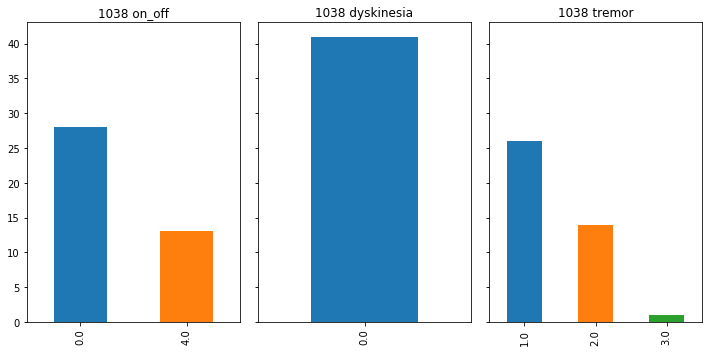

1039_train_kfold_0.csv
Nb subject_id :  1


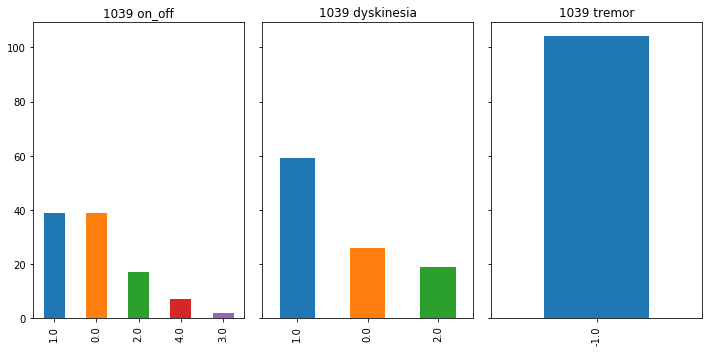

1039_test_kfold_0.csv
Nb subject_id :  1


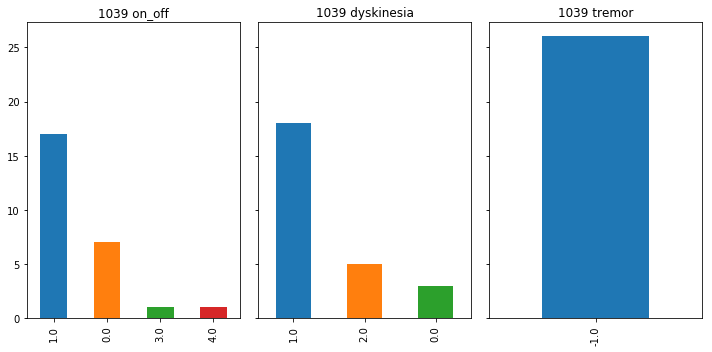

1039_train_kfold_1.csv
Nb subject_id :  1


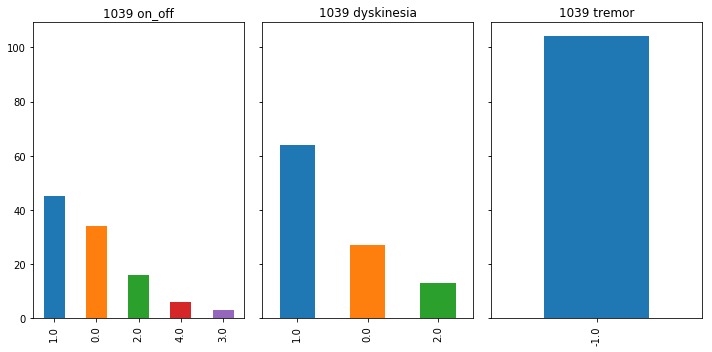

1039_test_kfold_1.csv
Nb subject_id :  1


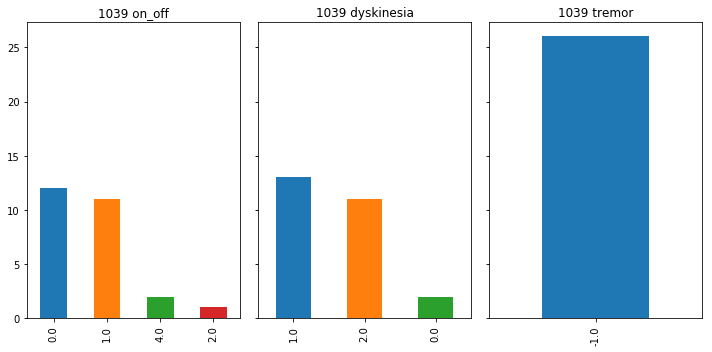

1039_train_kfold_2.csv
Nb subject_id :  1


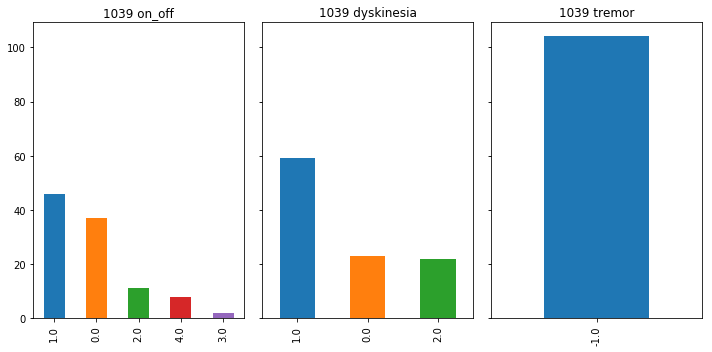

1039_test_kfold_2.csv
Nb subject_id :  1


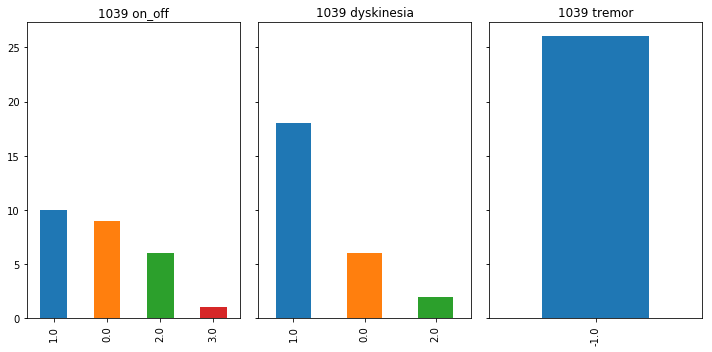

1039_train_kfold_3.csv
Nb subject_id :  1


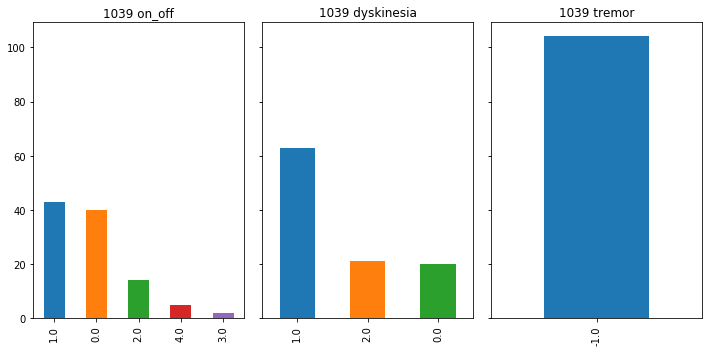

1039_test_kfold_3.csv
Nb subject_id :  1


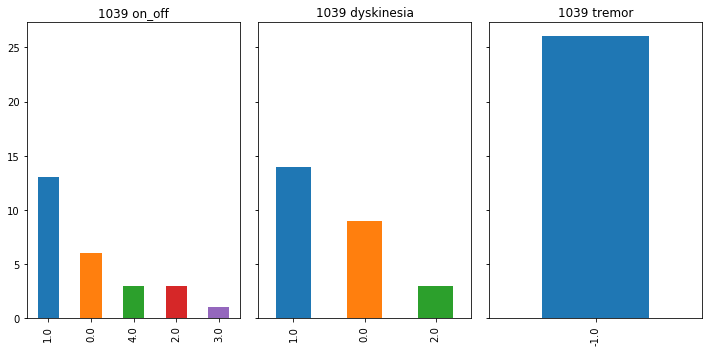

1039_train_kfold_4.csv
Nb subject_id :  1


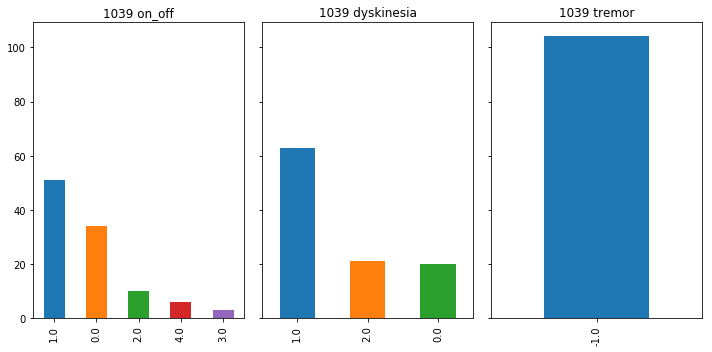

1039_test_kfold_4.csv
Nb subject_id :  1


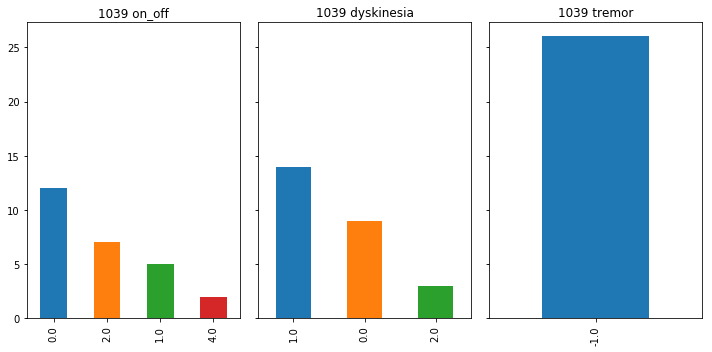

1043_train_kfold_0.csv
Nb subject_id :  1


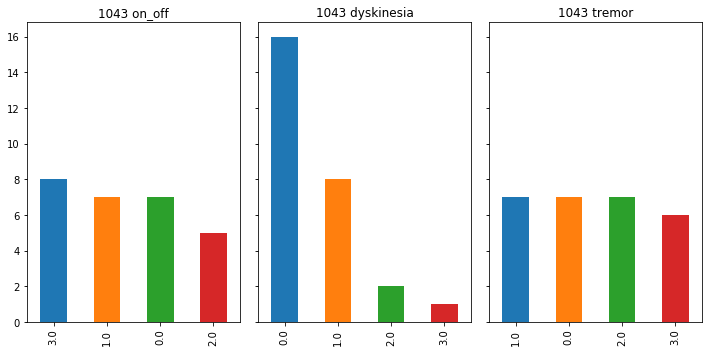

1043_test_kfold_0.csv
Nb subject_id :  1


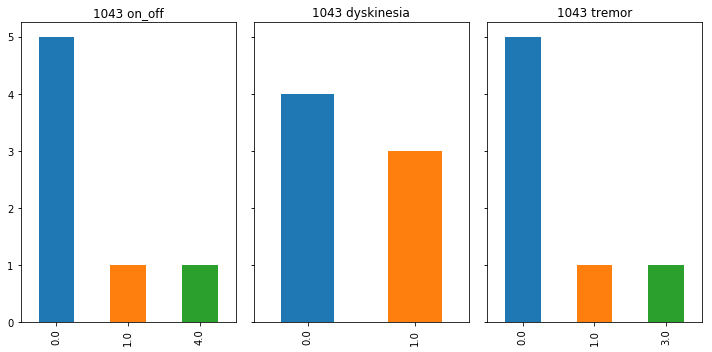

1043_train_kfold_1.csv
Nb subject_id :  1


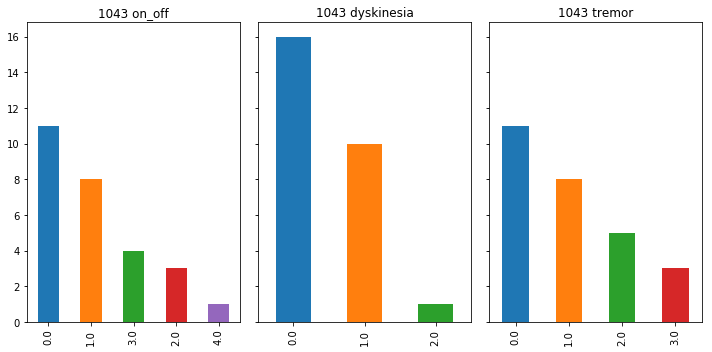

1043_test_kfold_1.csv
Nb subject_id :  1


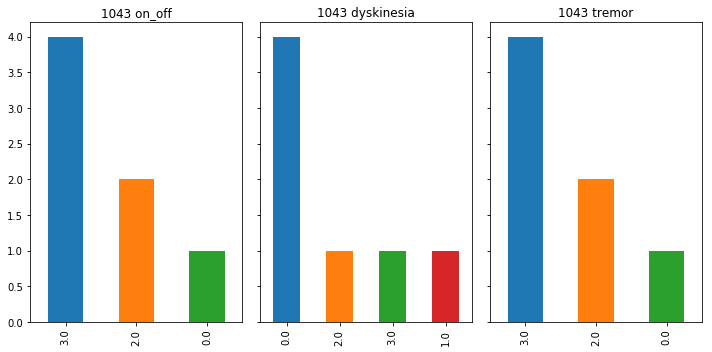

1043_train_kfold_2.csv
Nb subject_id :  1


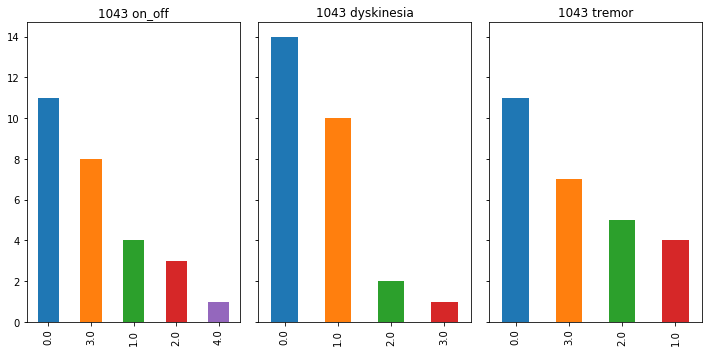

1043_test_kfold_2.csv
Nb subject_id :  1


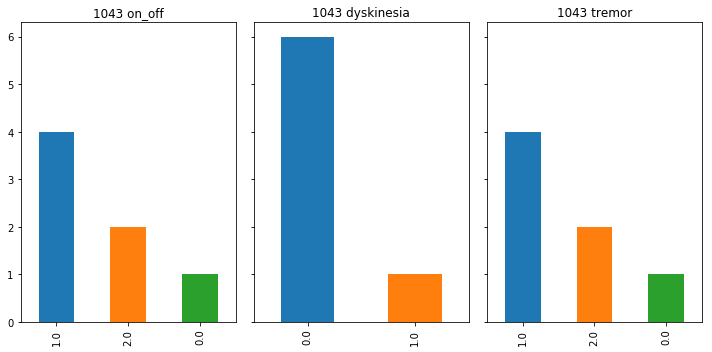

1043_train_kfold_3.csv
Nb subject_id :  1


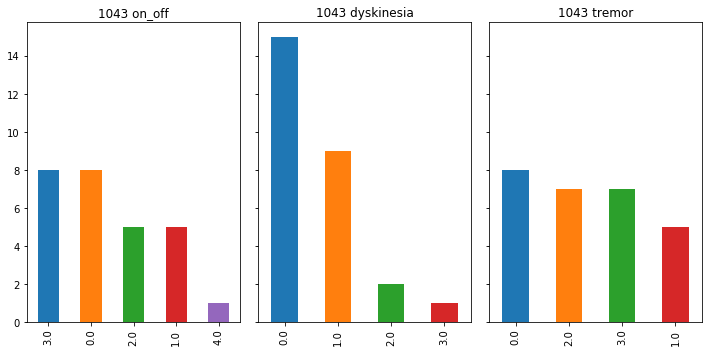

1043_test_kfold_3.csv
Nb subject_id :  1


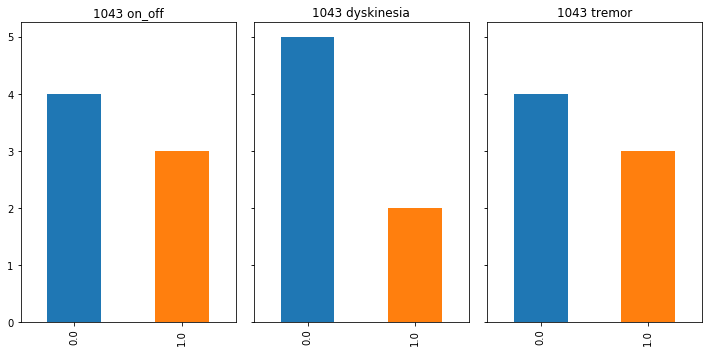

1043_train_kfold_4.csv
Nb subject_id :  1


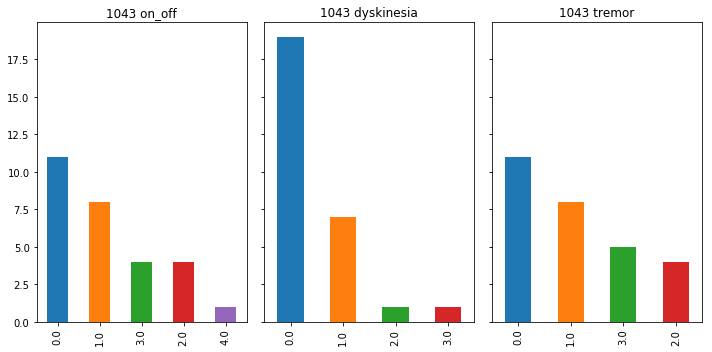

1043_test_kfold_4.csv
Nb subject_id :  1


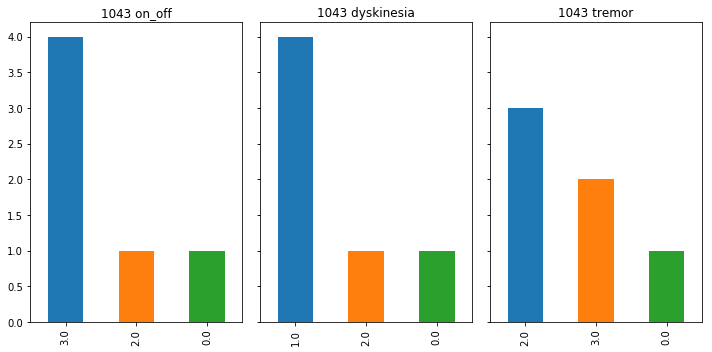

1044_train_kfold_0.csv
Nb subject_id :  1


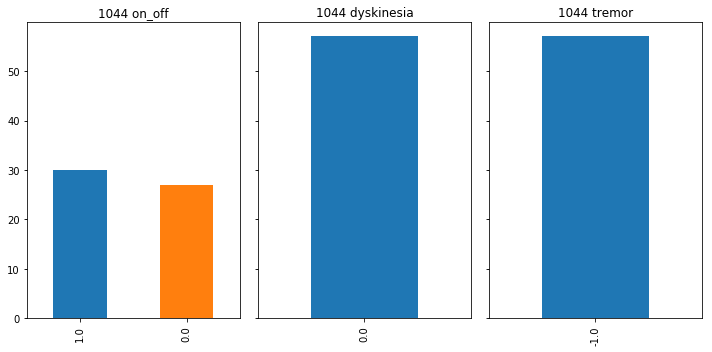

1044_test_kfold_0.csv
Nb subject_id :  1


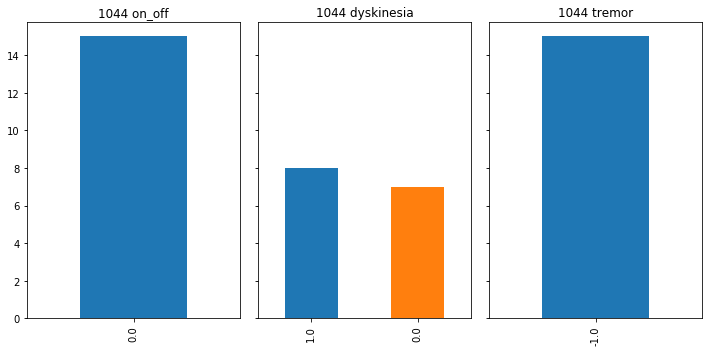

1044_train_kfold_1.csv
Nb subject_id :  1


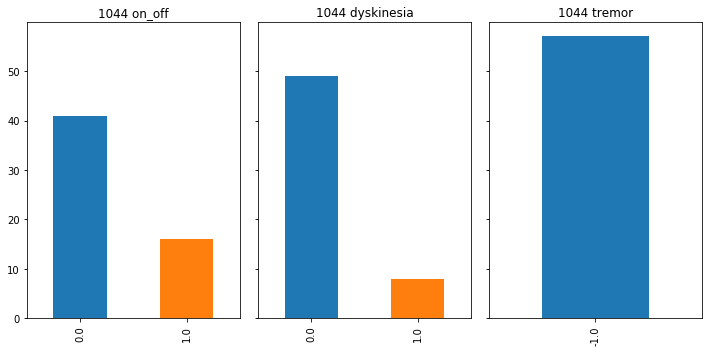

1044_test_kfold_1.csv
Nb subject_id :  1


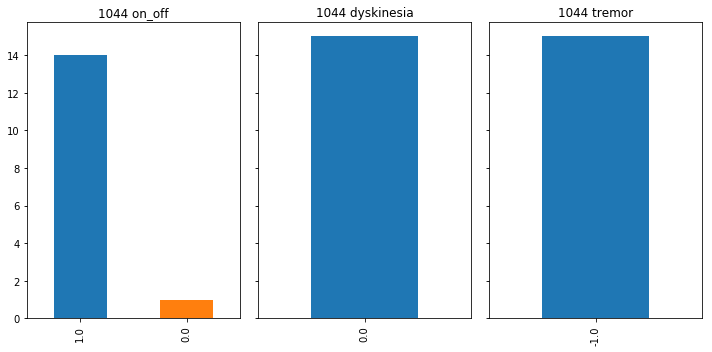

1044_train_kfold_2.csv
Nb subject_id :  1


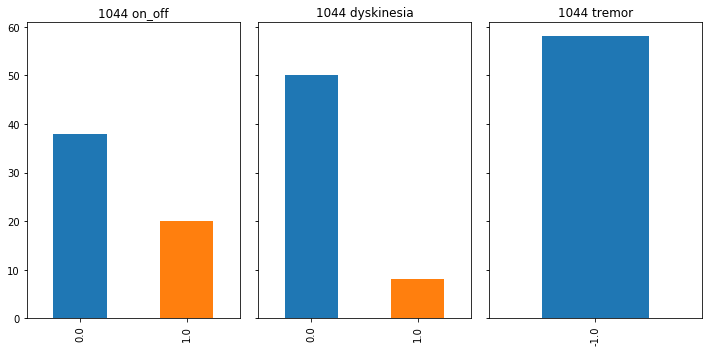

1044_test_kfold_2.csv
Nb subject_id :  1


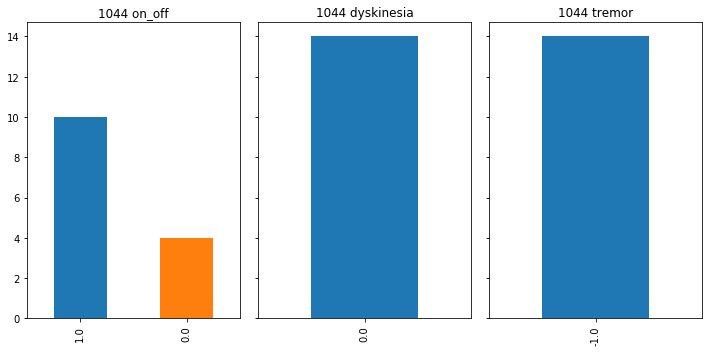

1044_train_kfold_3.csv
Nb subject_id :  1


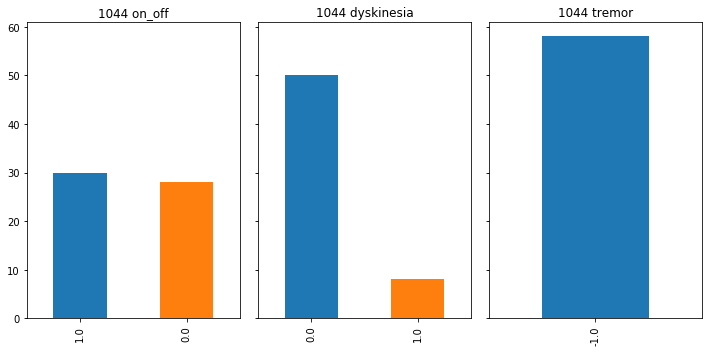

1044_test_kfold_3.csv
Nb subject_id :  1


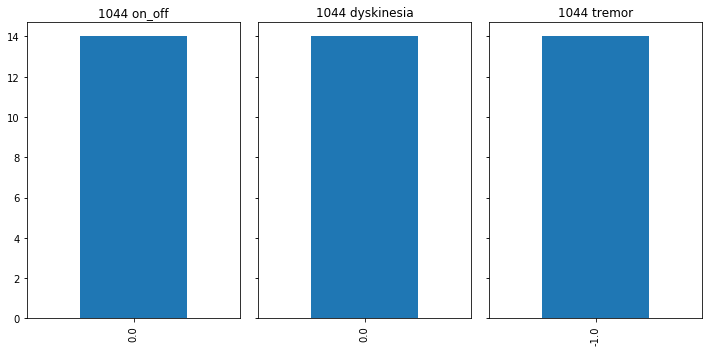

1044_train_kfold_4.csv
Nb subject_id :  1


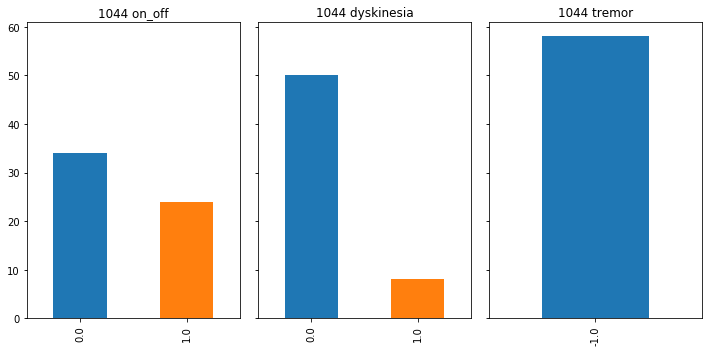

1044_test_kfold_4.csv
Nb subject_id :  1


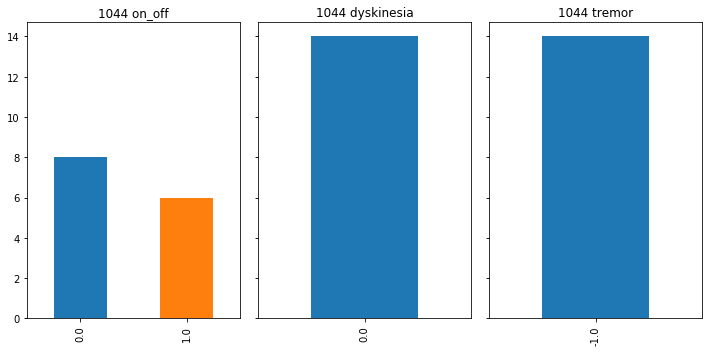

1046_train_kfold_0.csv
Nb subject_id :  1


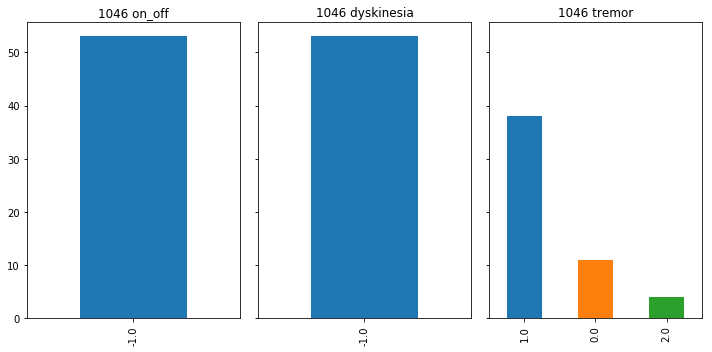

1046_test_kfold_0.csv
Nb subject_id :  1


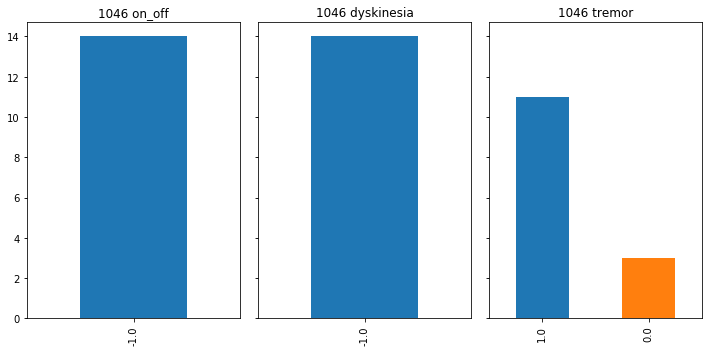

1046_train_kfold_1.csv
Nb subject_id :  1


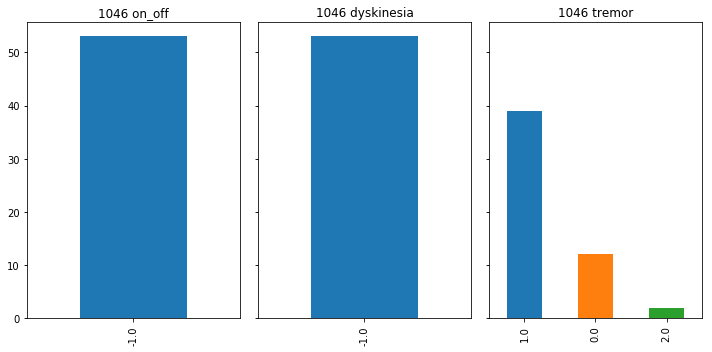

1046_test_kfold_1.csv
Nb subject_id :  1


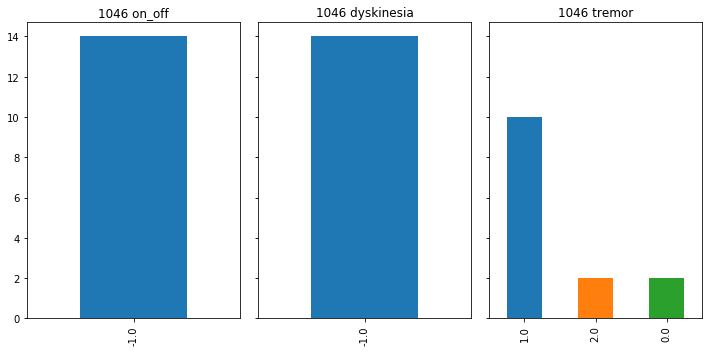

1046_train_kfold_2.csv
Nb subject_id :  1


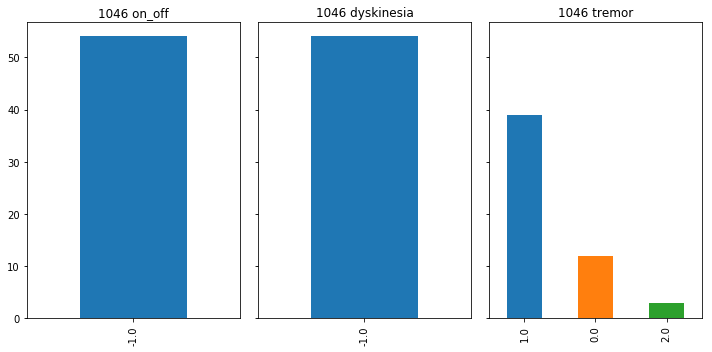

1046_test_kfold_2.csv
Nb subject_id :  1


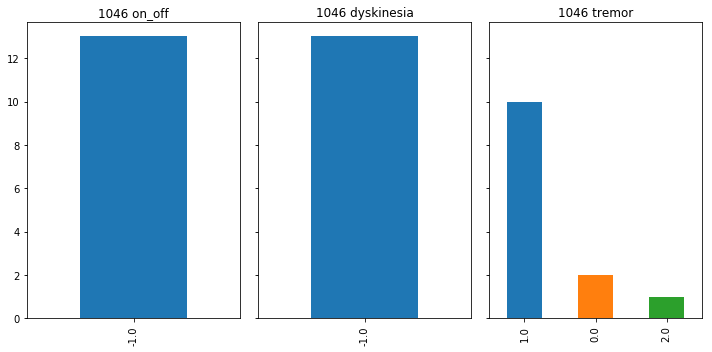

1046_train_kfold_3.csv
Nb subject_id :  1


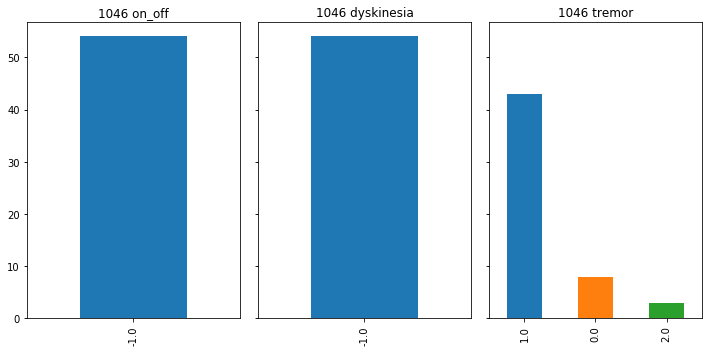

1046_test_kfold_3.csv
Nb subject_id :  1


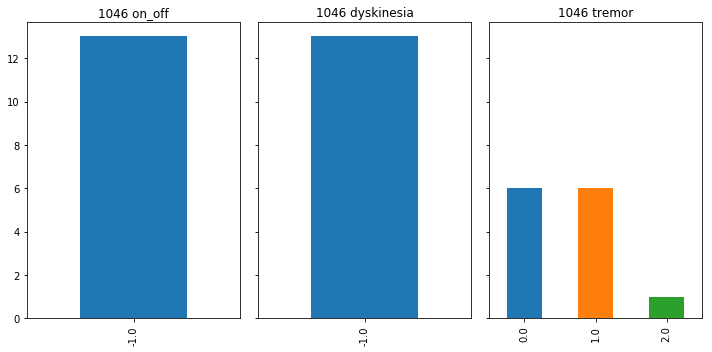

1046_train_kfold_4.csv
Nb subject_id :  1


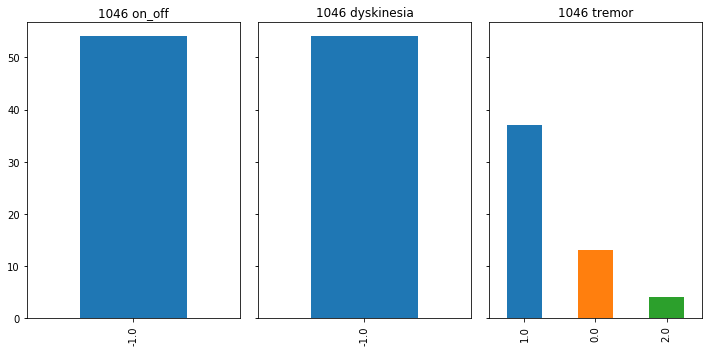

1046_test_kfold_4.csv
Nb subject_id :  1


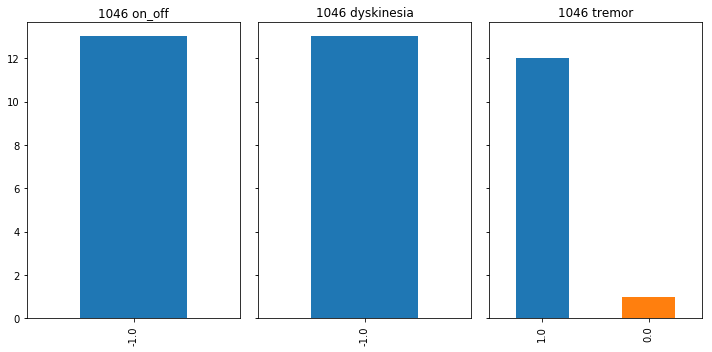

1048_train_kfold_0.csv
Nb subject_id :  1


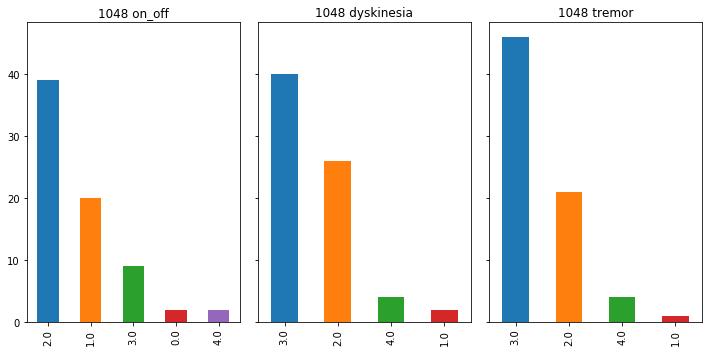

1048_test_kfold_0.csv
Nb subject_id :  1


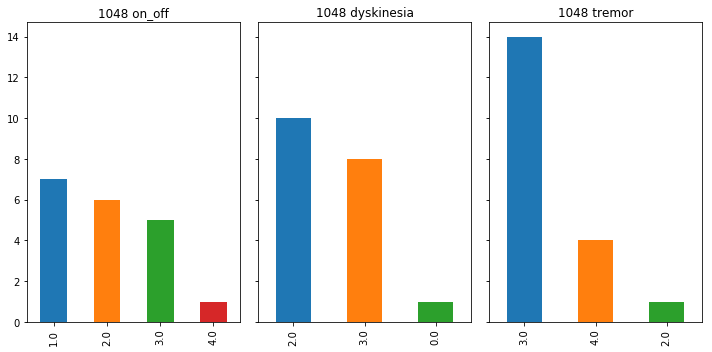

1048_train_kfold_1.csv
Nb subject_id :  1


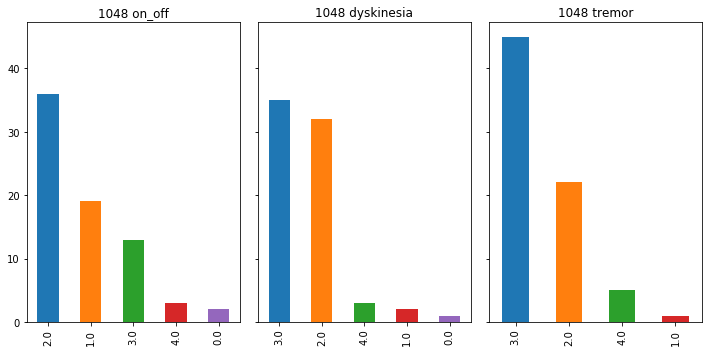

1048_test_kfold_1.csv
Nb subject_id :  1


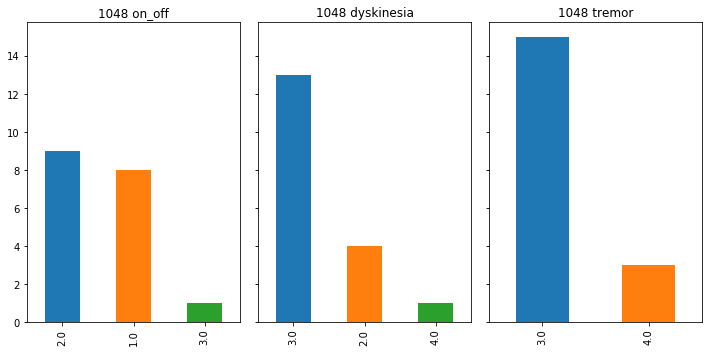

1048_train_kfold_2.csv
Nb subject_id :  1


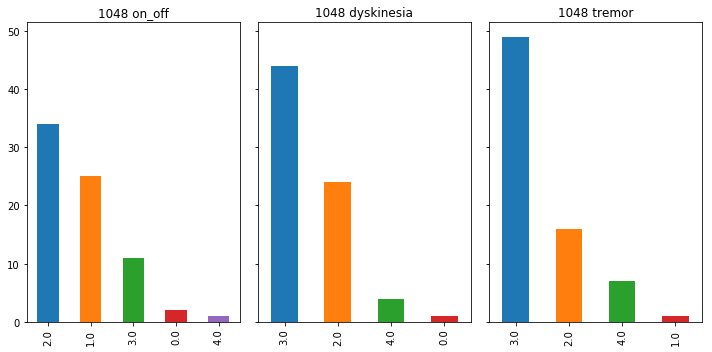

1048_test_kfold_2.csv
Nb subject_id :  1


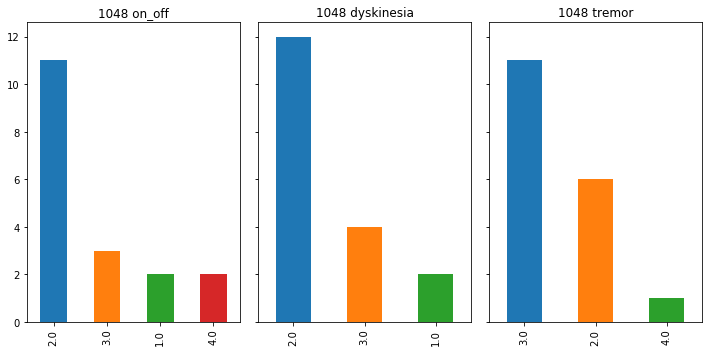

1048_train_kfold_3.csv
Nb subject_id :  1


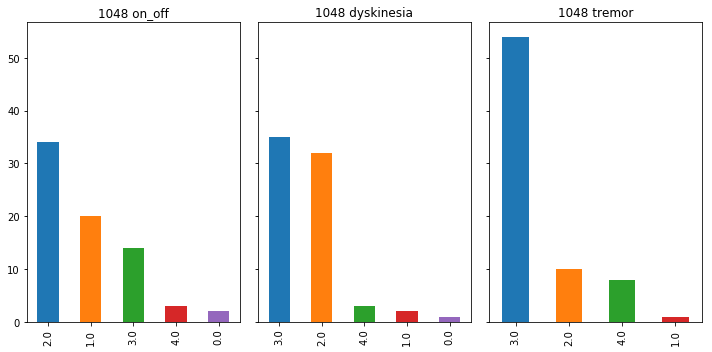

1048_test_kfold_3.csv
Nb subject_id :  1


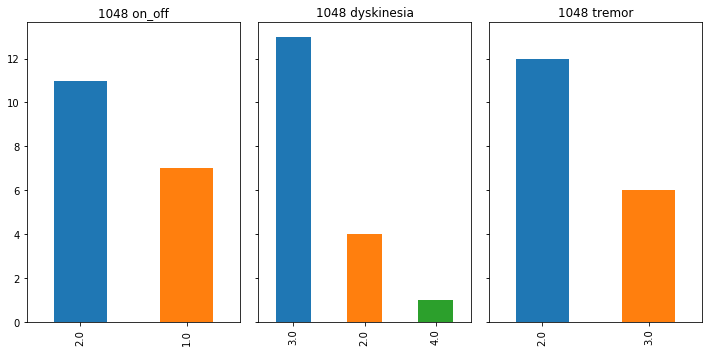

1048_train_kfold_4.csv
Nb subject_id :  1


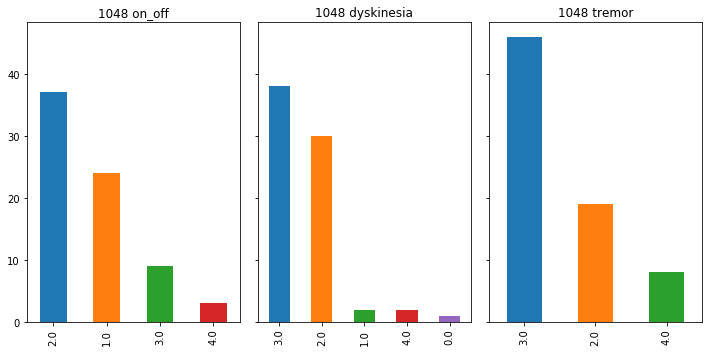

1048_test_kfold_4.csv
Nb subject_id :  1


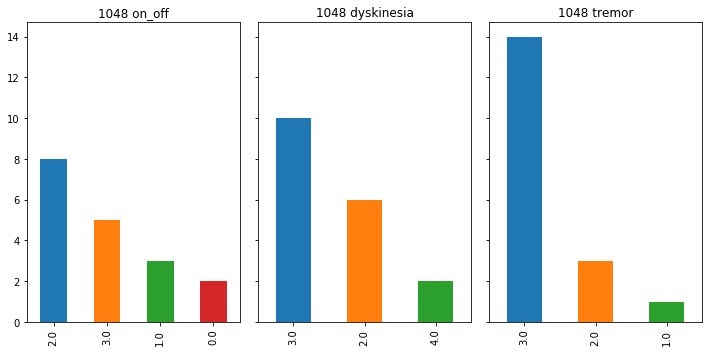

1049_train_kfold_0.csv
Nb subject_id :  1


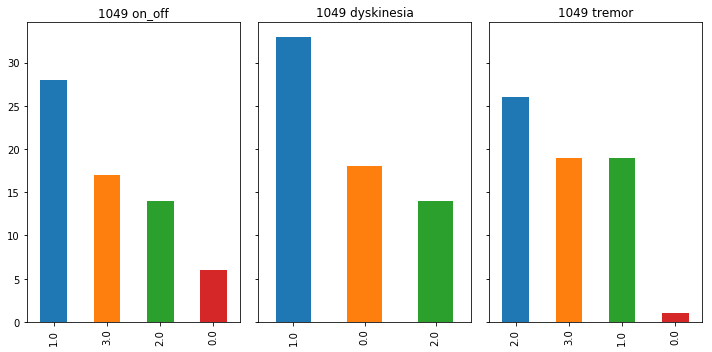

1049_test_kfold_0.csv
Nb subject_id :  1


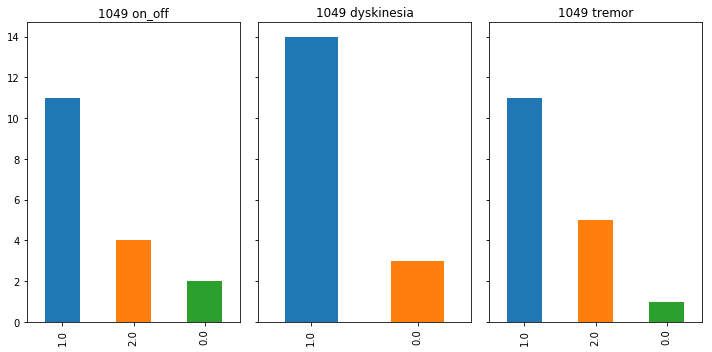

1049_train_kfold_1.csv
Nb subject_id :  1


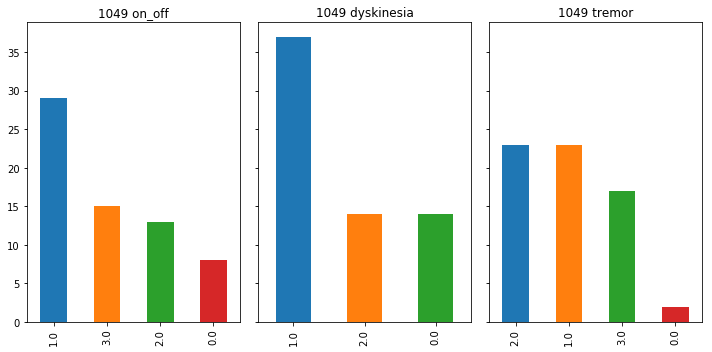

1049_test_kfold_1.csv
Nb subject_id :  1


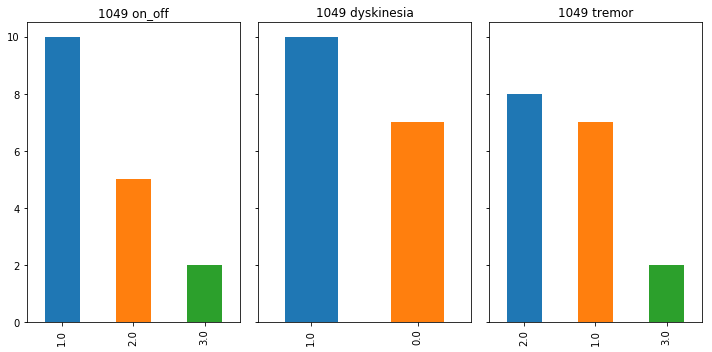

1049_train_kfold_2.csv
Nb subject_id :  1


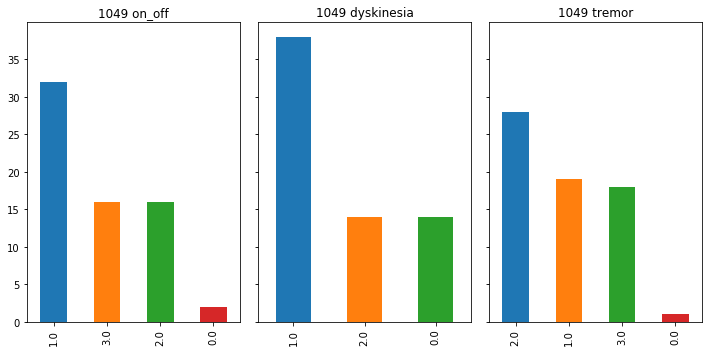

1049_test_kfold_2.csv
Nb subject_id :  1


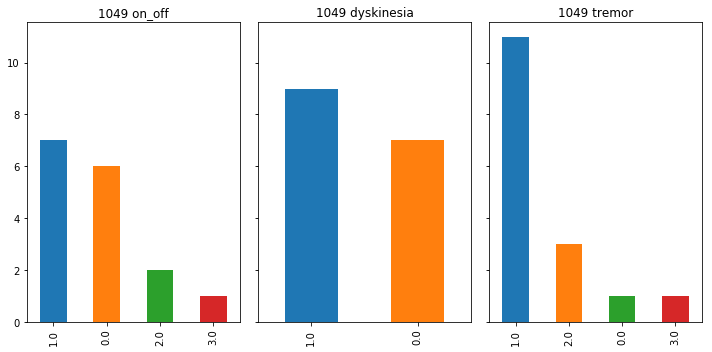

1049_train_kfold_3.csv
Nb subject_id :  1


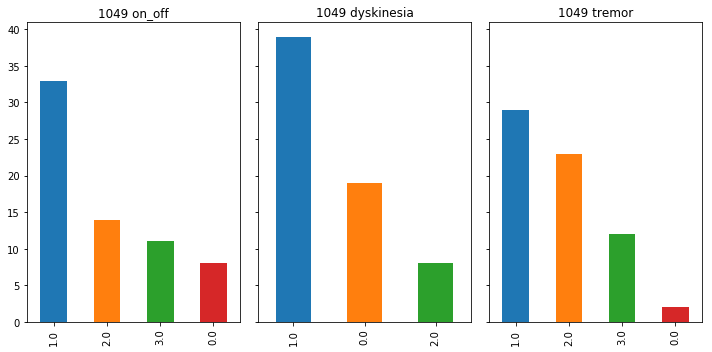

1049_test_kfold_3.csv
Nb subject_id :  1


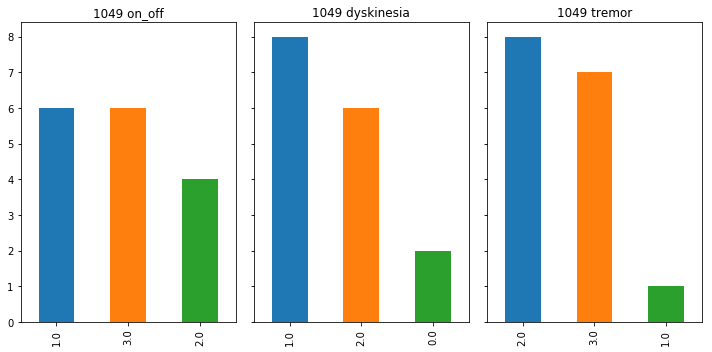

1049_train_kfold_4.csv
Nb subject_id :  1


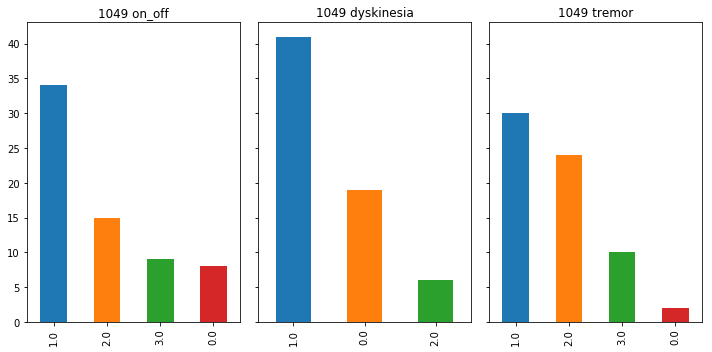

1049_test_kfold_4.csv
Nb subject_id :  1


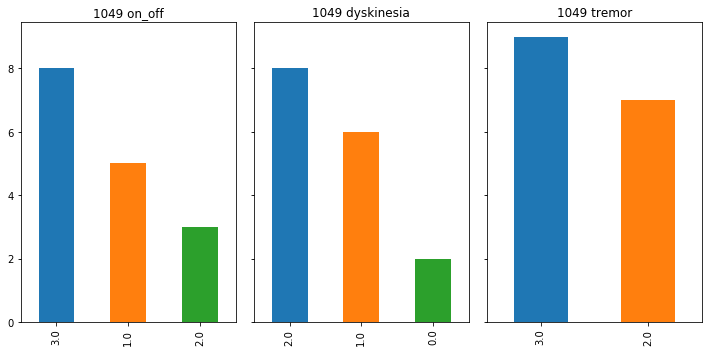

1051_train_kfold_0.csv
Nb subject_id :  1


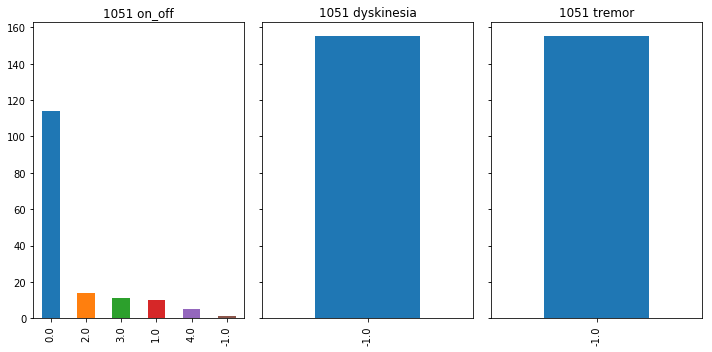

1051_test_kfold_0.csv
Nb subject_id :  1


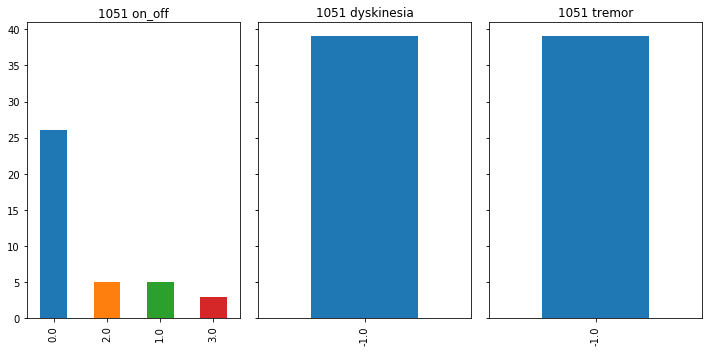

1051_train_kfold_1.csv
Nb subject_id :  1


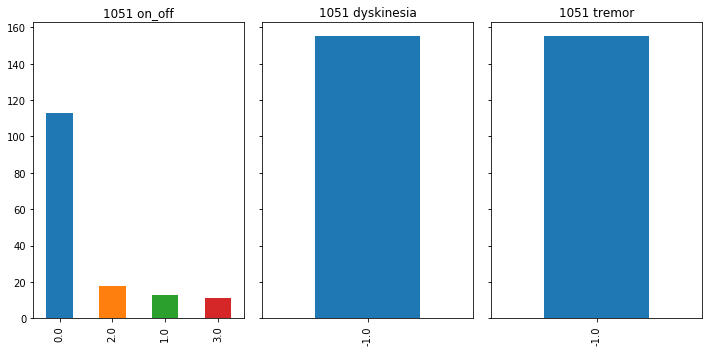

1051_test_kfold_1.csv
Nb subject_id :  1


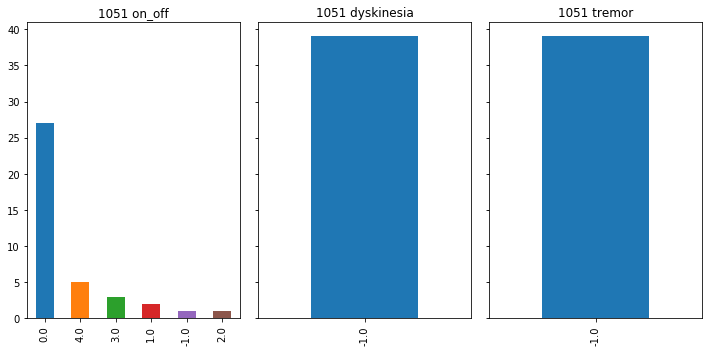

1051_train_kfold_2.csv
Nb subject_id :  1


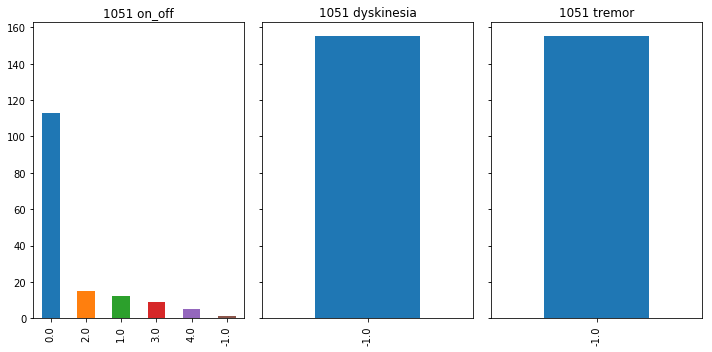

1051_test_kfold_2.csv
Nb subject_id :  1


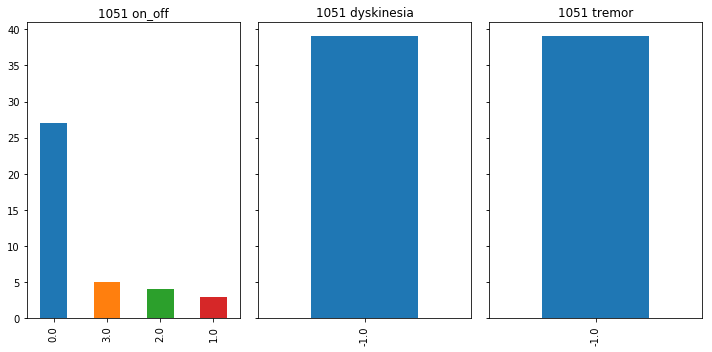

1051_train_kfold_3.csv
Nb subject_id :  1


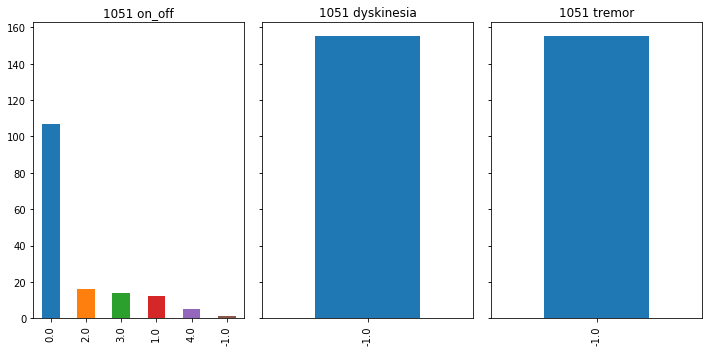

1051_test_kfold_3.csv
Nb subject_id :  1


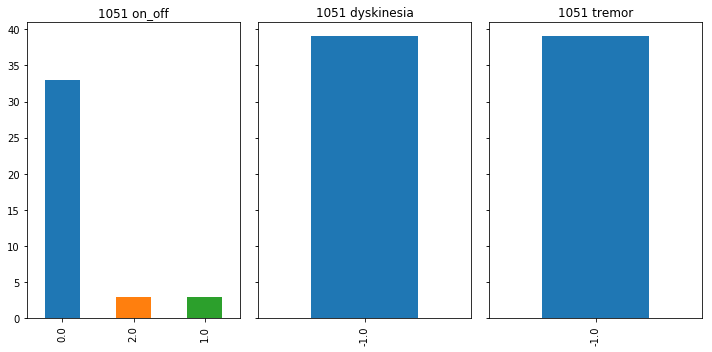

1051_train_kfold_4.csv
Nb subject_id :  1


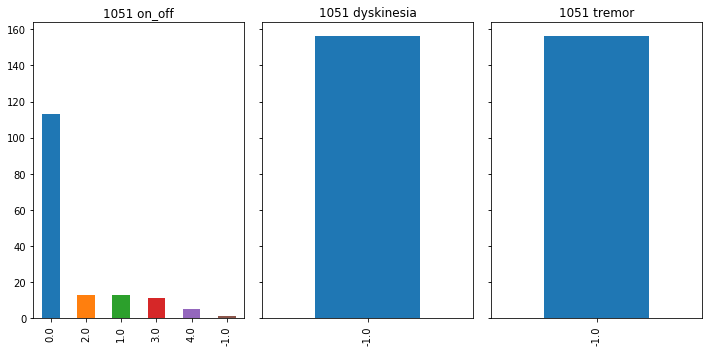

1051_test_kfold_4.csv
Nb subject_id :  1


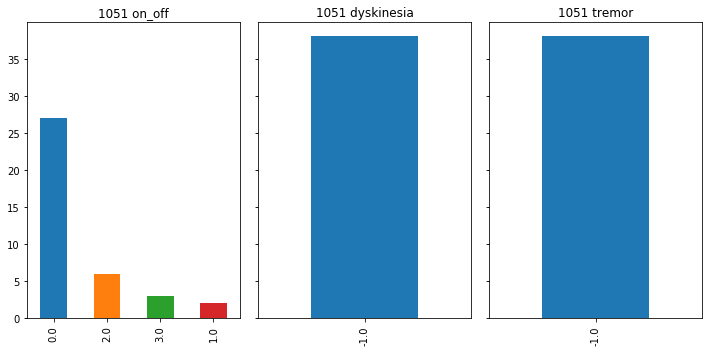

In [47]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v1/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

In [11]:
df_occurences, df_train_label_subject_id

(   subject_id     symptom  symptom_value  occurence
 0        1051      on_off            0.0        113
 1        1051      on_off            2.0         13
 2        1051      on_off            1.0         13
 3        1051      on_off            3.0         11
 4        1051      on_off            4.0          5
 5        1051      on_off           -1.0          1
 6        1051  dyskinesia           -1.0        156
 7        1051      tremor           -1.0        156,
 <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x7fd901161b70>)

#1
Nb subject_id h:  1
#2
axes
(3,)
AxesSubplot(0.125,0.125;0.227941x0.755)
#3
#4
#4.5
 0.0    113
 2.0     13
 1.0     13
 3.0     11
 4.0      5
-1.0      1
Name: on_off, dtype: int64
patient :  0
#5
#4
#4.5
-1.0    156
Name: dyskinesia, dtype: int64
patient :  0
#5
#4
#4.5
-1.0    156
Name: tremor, dtype: int64
patient :  0
#5


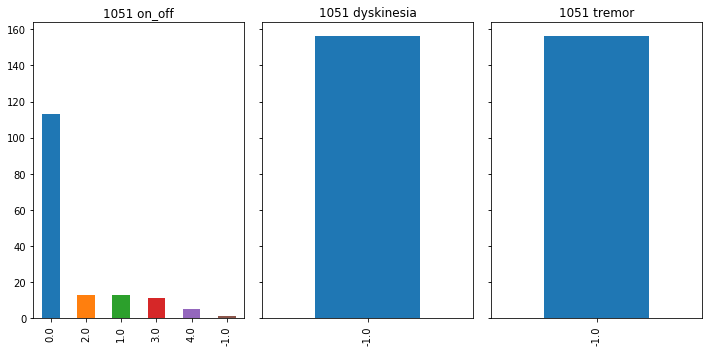